c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\markm\miniconda3\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************

Data preparation complete.
Optimal number of features: 115


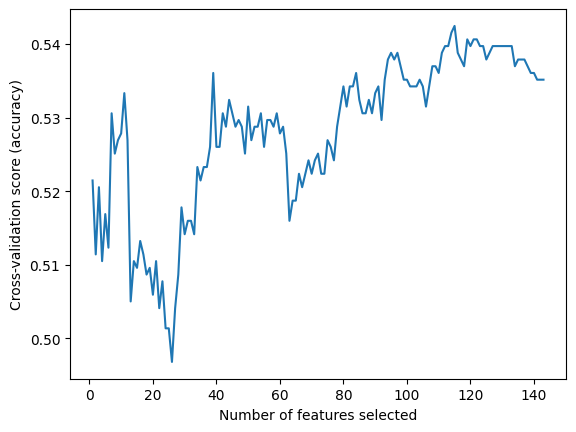

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller
from fracdiff.sklearn import FracdiffStat
import yfinance as yf
from fredapi import Fred
from ta import add_all_ta_features
import matplotlib.pyplot as plt


API_KEY = "1e074c3898d6261abc56ff5962358644"
STOCK_TICKER = "AAPL"
MARKET_TICKER = "^GSPC"
START_DATE = "2018-01-02"
END_DATE = "2024-01-01"
SERIES_IDS = {
    "DGS10": "DGS10",
    "VIXCLS": "VIXCLS",
    "CRUDEOILWTI": "DCOILWTICO",
    "DCOILBRENTEU": "DCOILBRENTEU",
    "FFER": "DFF",
    "USDollarIndex": "DTWEXBGS",
}


fred = Fred(api_key=API_KEY)


def safe_api_call(call, *args, **kwargs):
    try:
        return call(*args, **kwargs)
    except Exception as e:
        print(f"API call failed: {e}")
        return pd.DataFrame()  # Return empty DataFrame on failure


def download_fred_series(series_id: str) -> pd.Series:
    return safe_api_call(fred.get_series, series_id)


def download_and_process_yfinance_data(
    ticker: str, start_date: str, end_date: str
) -> pd.DataFrame:
    data = safe_api_call(yf.download, ticker, start=start_date, end=end_date)
    if not data.empty:
        data.index = pd.DatetimeIndex(
            data.index
        ).normalize()  # Normalize to remove time
        data = data.reindex(
            pd.date_range(start=start_date, end=end_date, freq="B"), method="ffill"
        )
    return data


def process_macroeconomic_data(start_date: str, end_date: str) -> pd.DataFrame:
    macro_df = pd.DataFrame(
        index=pd.date_range(start=start_date, end=end_date, freq="B")
    )
    for name, series_id in SERIES_IDS.items():
        series = download_fred_series(series_id)
        if series is not None:
            macro_df[name] = series.reindex(macro_df.index, method="ffill")
    return macro_df


def combine_all_data(stock_data, market_data, macro_data, additional_data):
    combined_data = stock_data.join(
        market_data[["Close"]].rename(columns={"Close": "MarketClose"}), how="left"
    ).fillna(method="ffill")
    combined_data = combined_data.join(macro_data, how="left").fillna(method="ffill")
    for name, data in additional_data.items():
        combined_data = combined_data.join(
            data[["Close"]].rename(columns={"Close": f"{name}Close"}), how="left"
        ).fillna(method="ffill")
    return combined_data


def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    data = add_all_ta_features(
        data,
        open="Open",
        high="High",
        low="Low",
        close="Close",
        volume="Volume",
        fillna=True,
    )
    data["Target"] = (data["Close"].shift(-1) > data["Close"]).astype(int)
    return data.dropna()


def apply_fractional_differencing(
    df: pd.DataFrame, threshold: float = 0.05
) -> pd.DataFrame:
    f_diff = FracdiffStat()
    for column in df.columns.difference(["Target"]):
        p_value = adfuller(df[column])[1]
        if p_value > threshold:
            transformed_column = f_diff.fit_transform(df[[column]])
            df[column + "_fdiff"] = transformed_column.squeeze()
    return df


def perform_feature_selection_with_rfecv(X_train, y_train):
    """
    Performs feature selection using RFECV (Recursive Feature Elimination with Cross-Validation).

    Parameters:
    - X_train: Training features DataFrame.
    - y_train: Training target vector.

    Returns:
    - A tuple of (selector, X_train_selected), where selector is the fitted RFECV instance and
      X_train_selected is the DataFrame of selected features.
    """
    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Initialize the model
    model = LogisticRegression(max_iter=1000, solver='liblinear')
    
    # Initialize RFECV
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    
    # Fit RFECV
    rfecv.fit(X_train_scaled, y_train)
    
    print("Optimal number of features: %d" % rfecv.n_features_)
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score (accuracy)")
    # Adjusting for the change in attribute name
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    plt.show()

    
    # Select features based on RFECV
    X_train_selected = X_train.iloc[:, rfecv.support_]
    
    return rfecv, X_train_selected


def main():
    stock_data = download_and_process_yfinance_data(STOCK_TICKER, START_DATE, END_DATE)
    market_data = download_and_process_yfinance_data(
        MARKET_TICKER, START_DATE, END_DATE
    )
    macro_data = process_macroeconomic_data(START_DATE, END_DATE)

    additional_data = {
        "GoldPrices": download_and_process_yfinance_data("GC=F", START_DATE, END_DATE),
        "OilPrices": download_and_process_yfinance_data("CL=F", START_DATE, END_DATE),
    }

    combined_data = combine_all_data(
        stock_data, market_data, macro_data, additional_data
    )
    preprocessed_data = preprocess_data(combined_data)
    final_dataset = apply_fractional_differencing(preprocessed_data)

    print("Data preparation complete.")

    # Split the dataset into features and target
    X = final_dataset.drop('Target', axis=1)
    y = final_dataset['Target']
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Perform feature selection with RFECV
    rfecv, X_train_selected = perform_feature_selection_with_rfecv(X_train, y_train)
    
    # Transform test set
    X_test_selected = X_test.iloc[:, rfecv.support_]
    
    # Continue with model training and evaluation using X_train_selected and X_test_selected
    
    return X_train_selected, X_test_selected, y_train, y_test


if __name__ == "__main__":
    X_train_selected, X_test_selected, y_train, y_test = main()

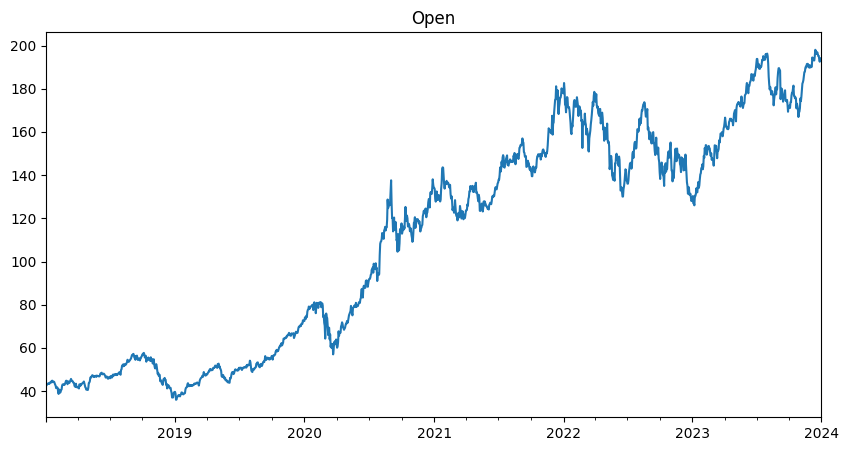

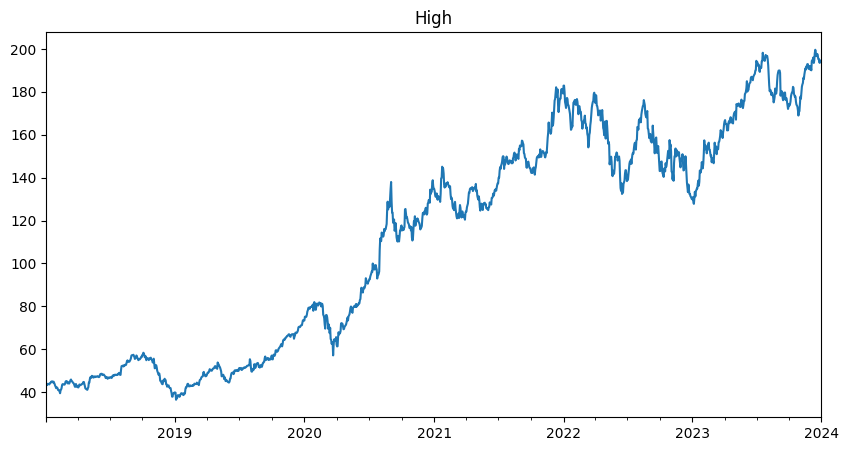

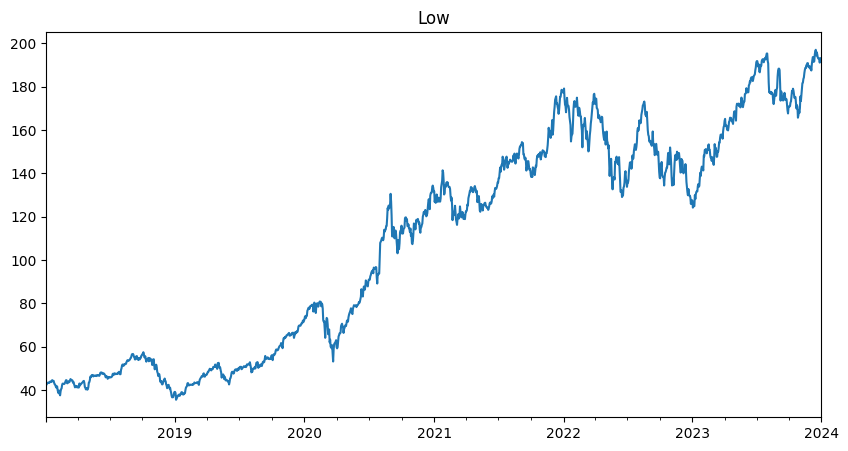

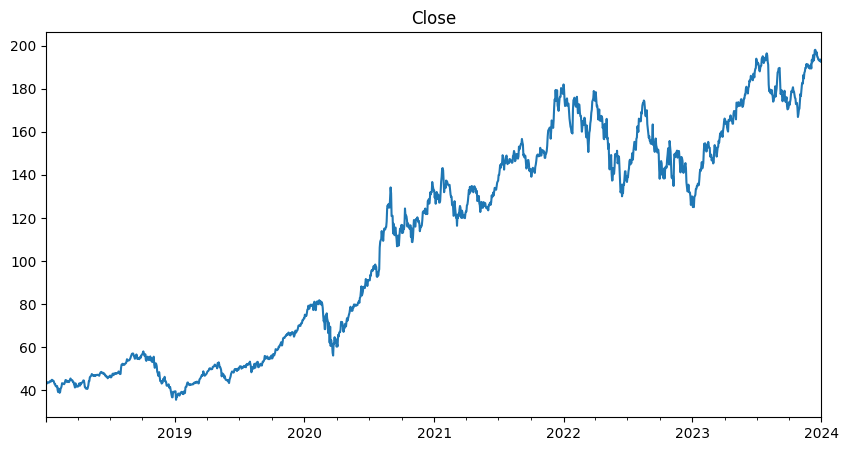

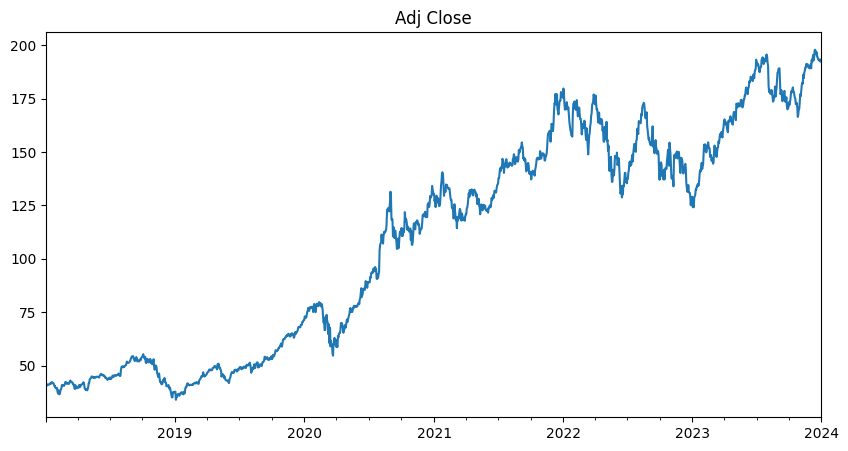

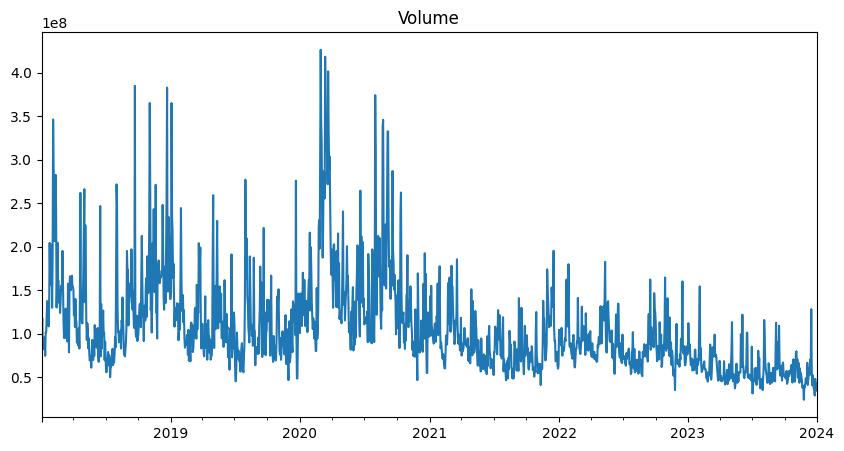

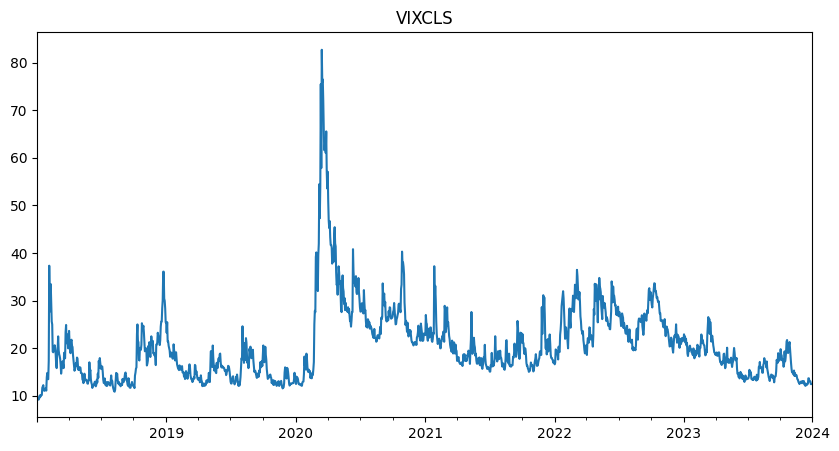

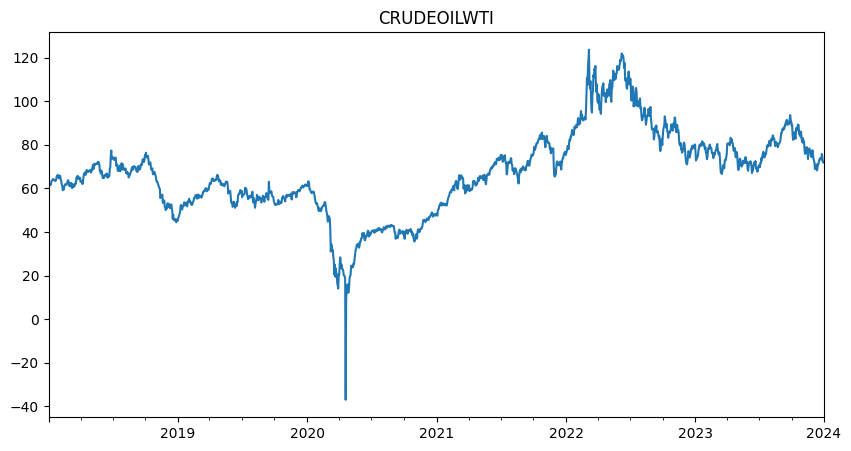

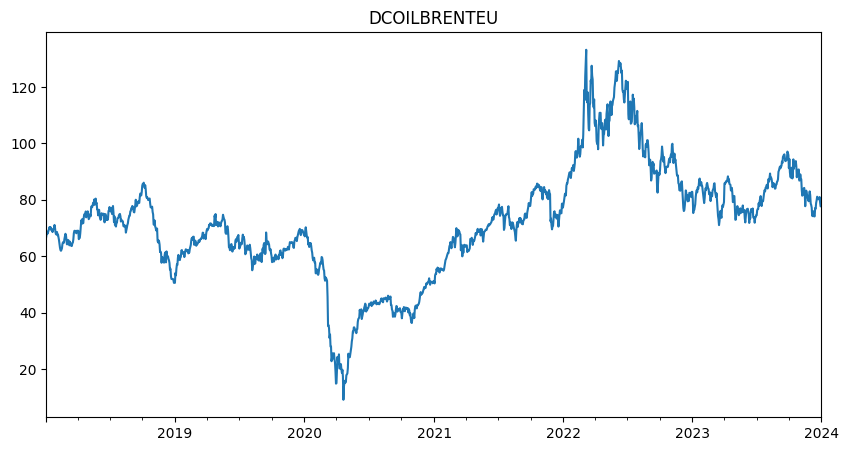

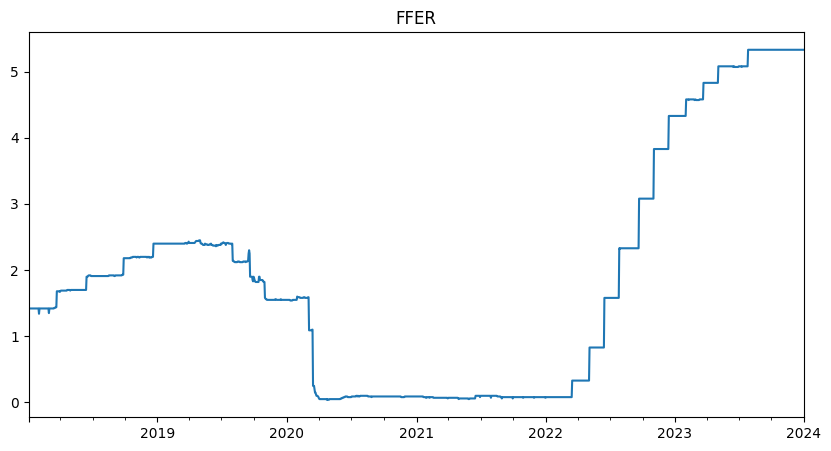

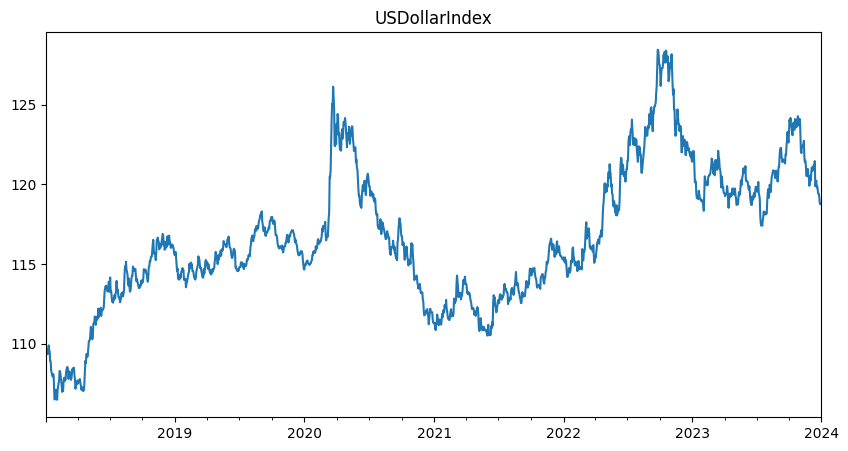

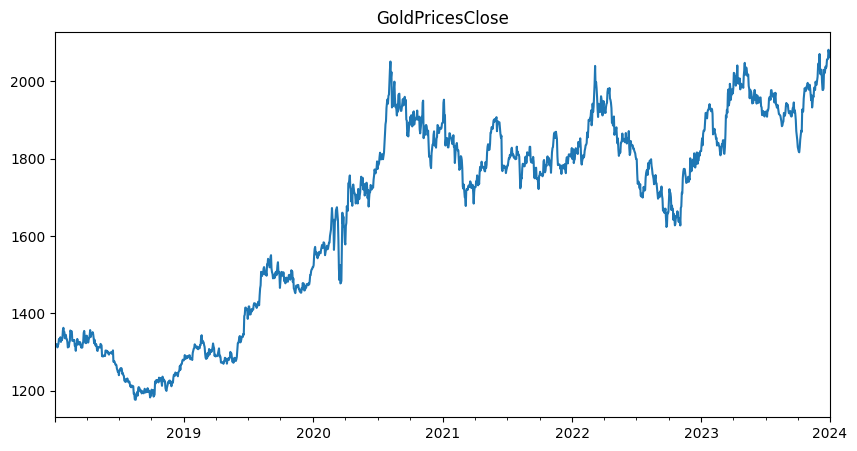

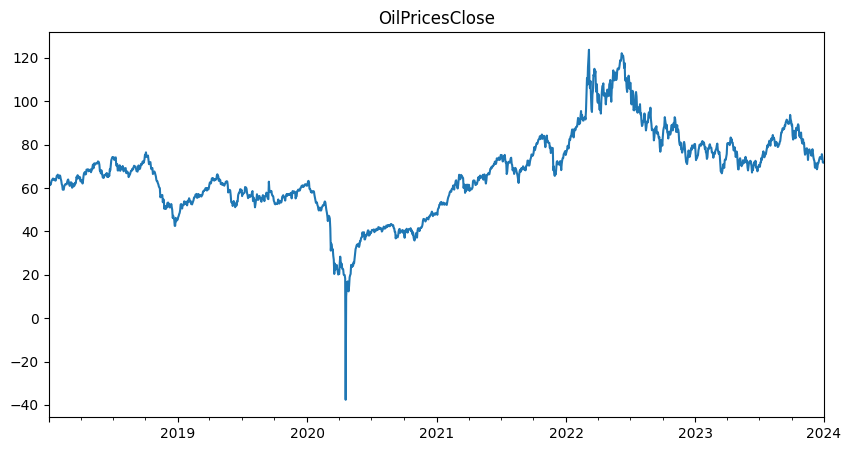

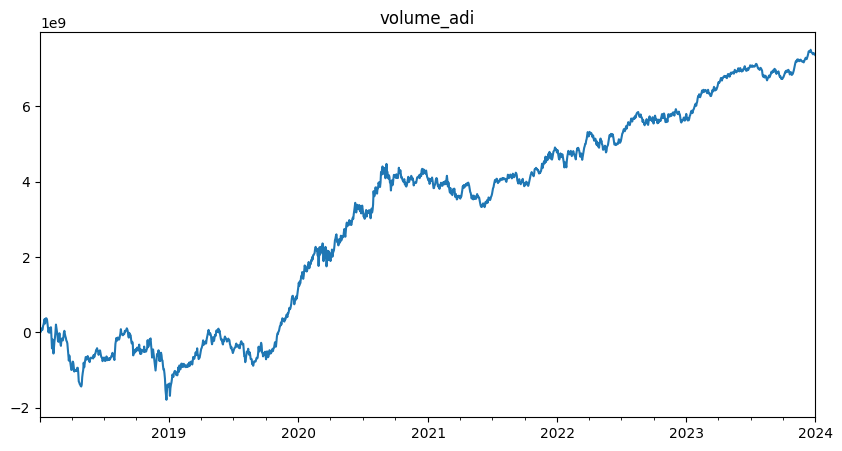

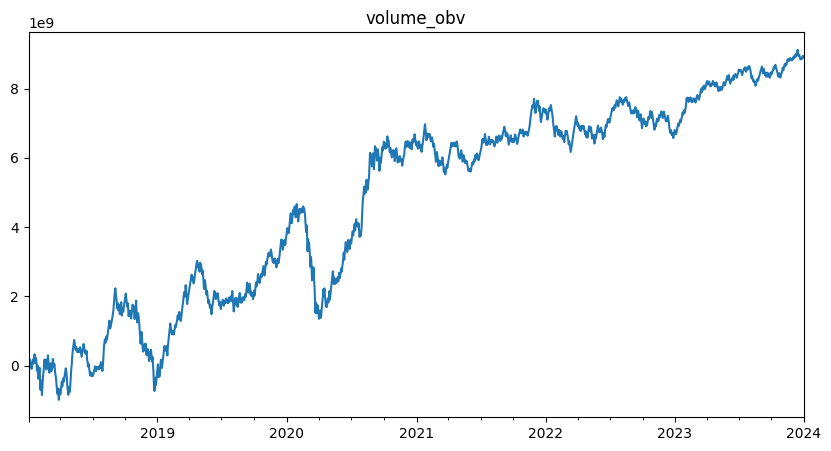

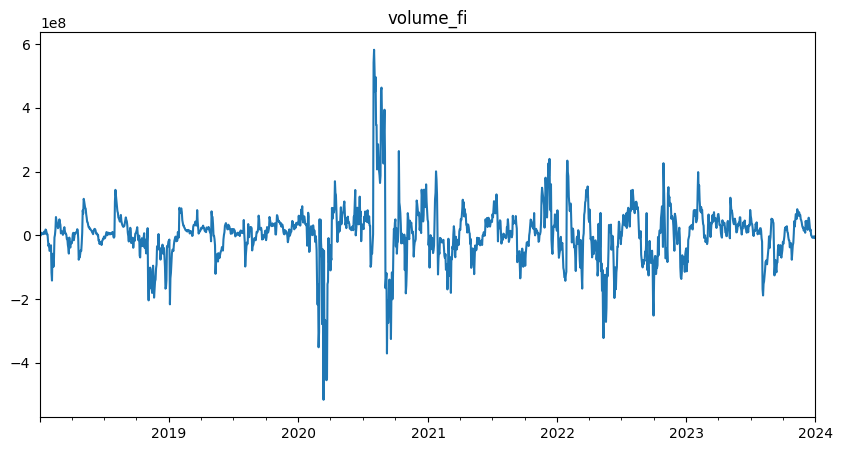

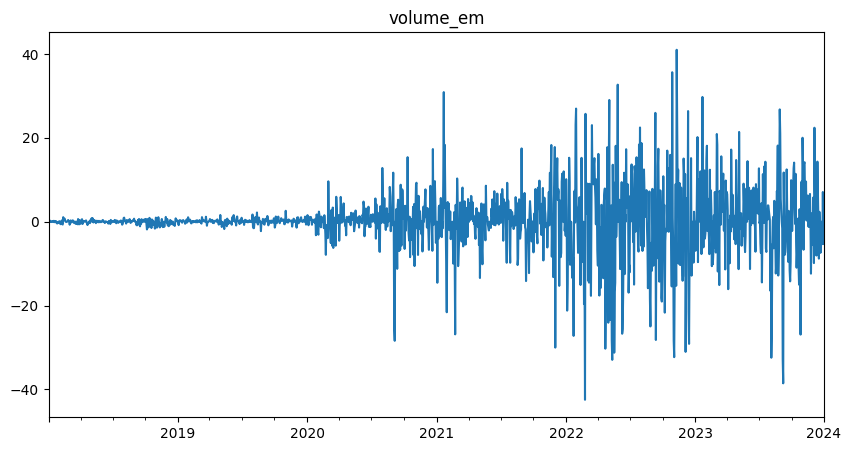

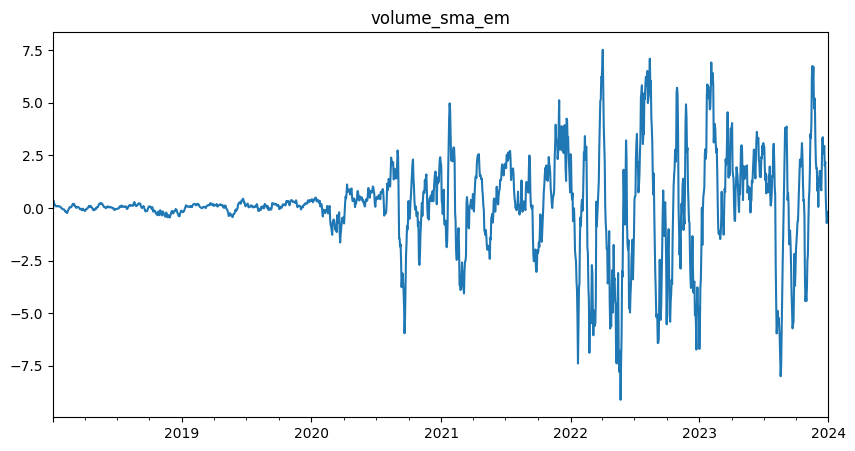

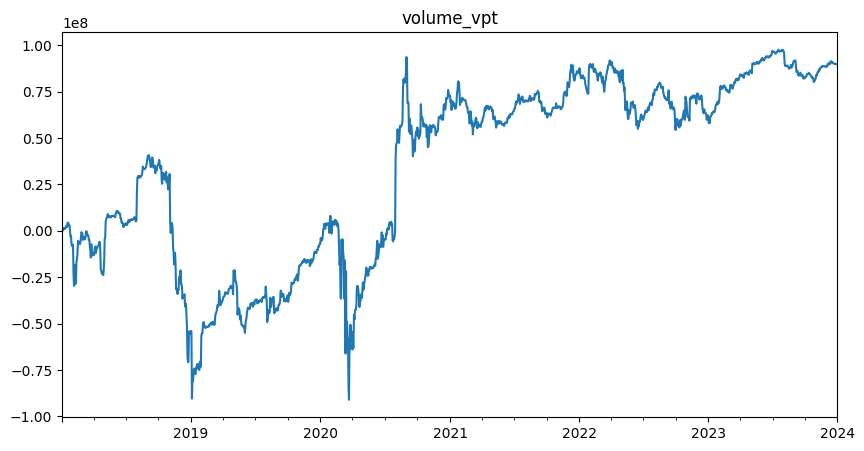

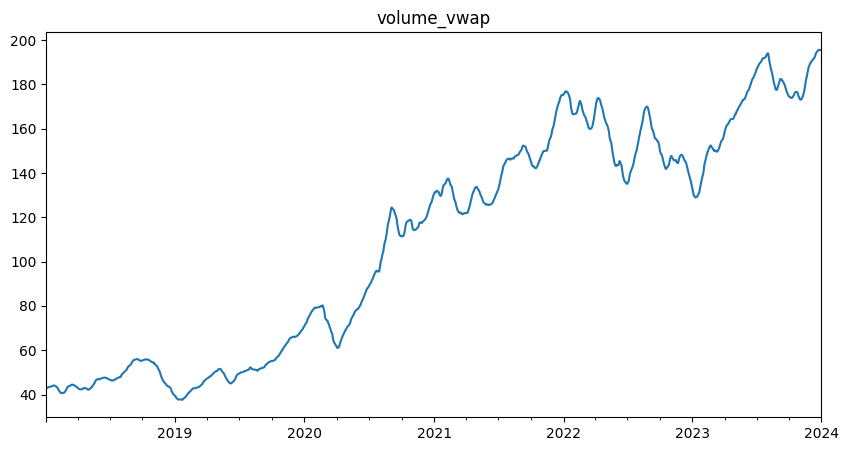

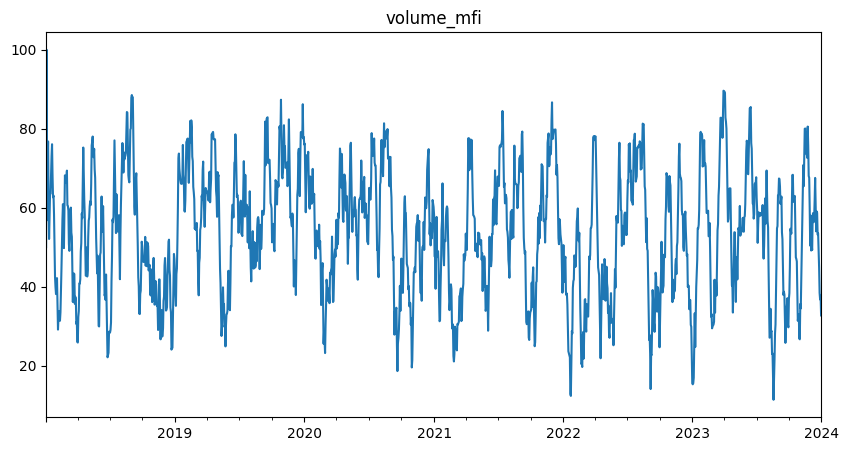

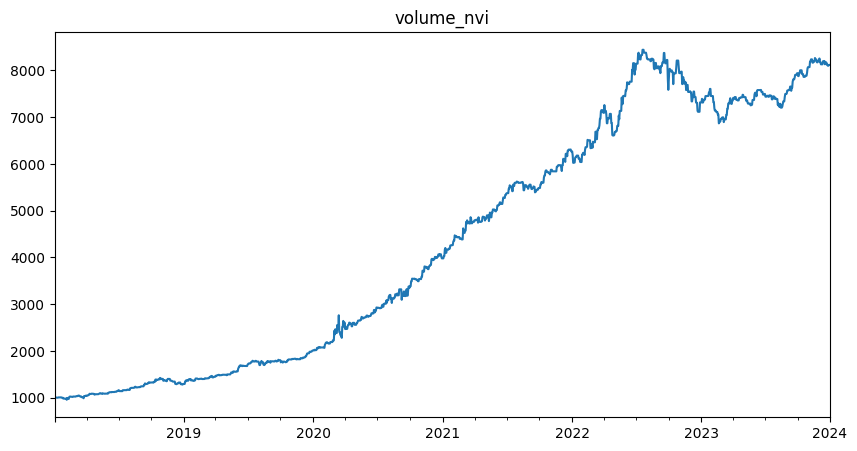

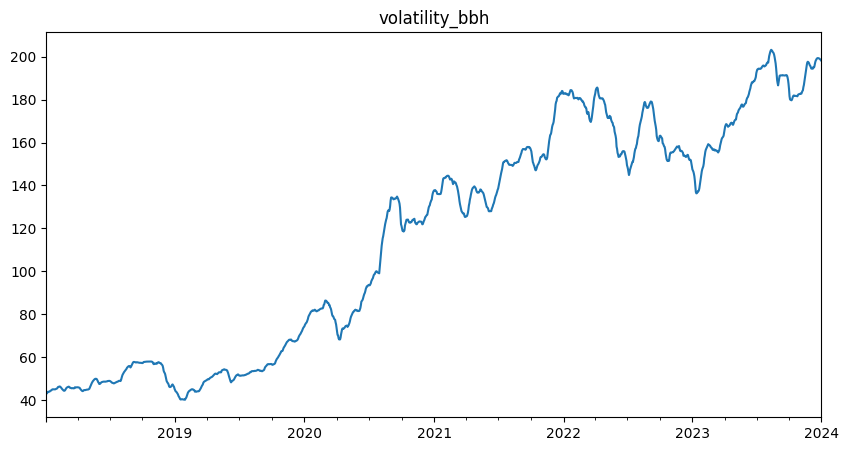

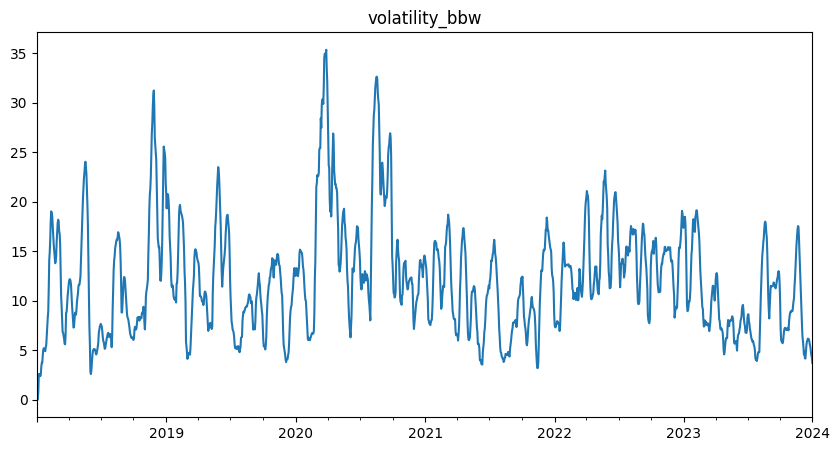

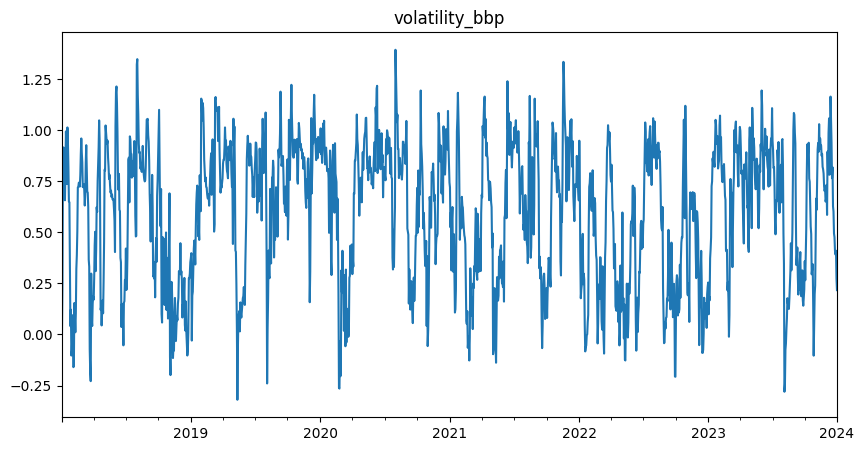

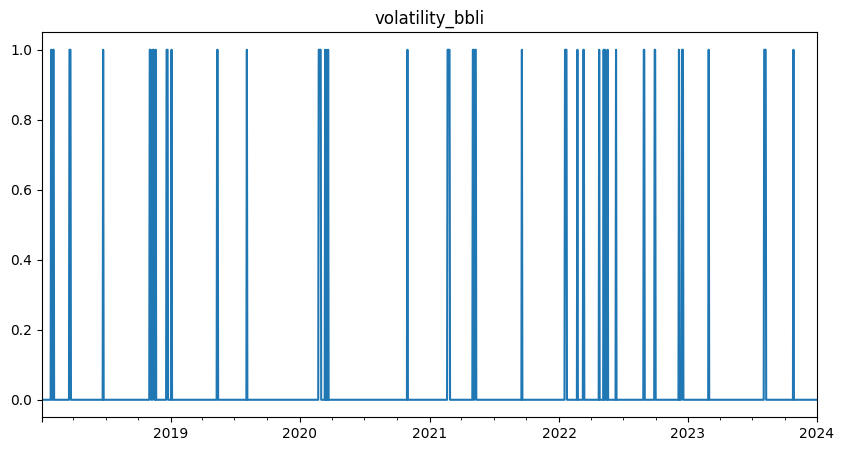

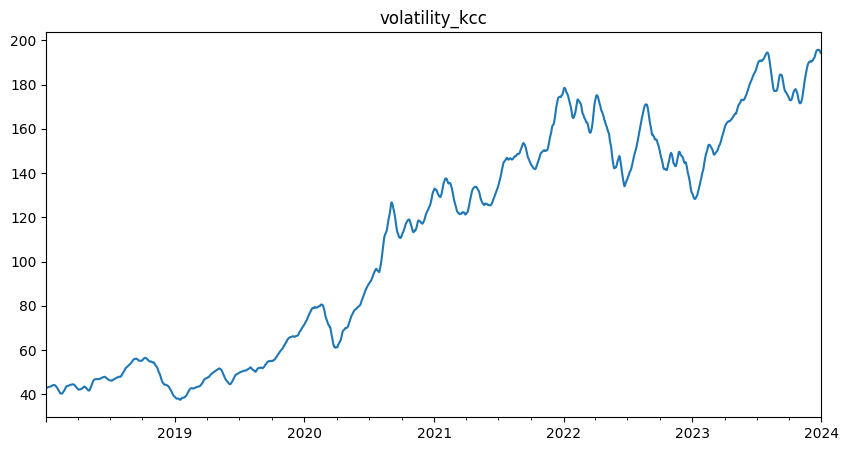

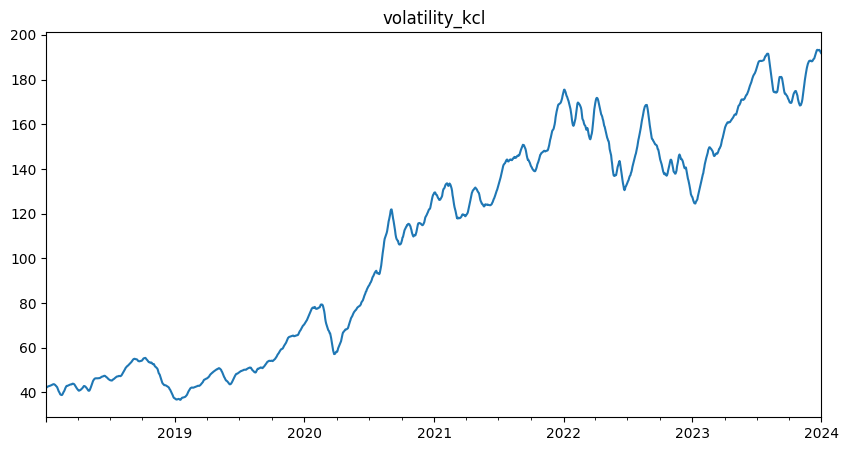

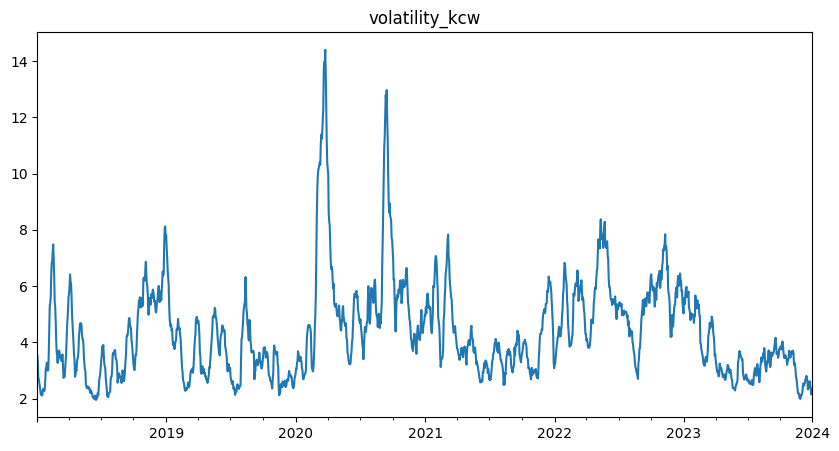

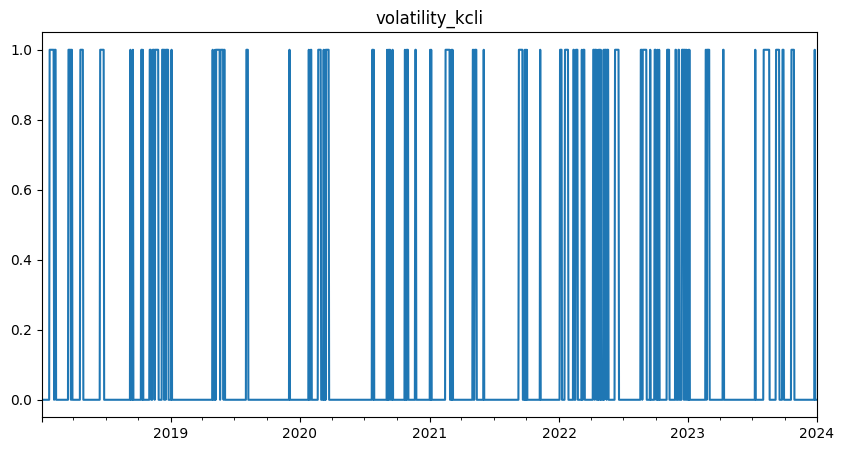

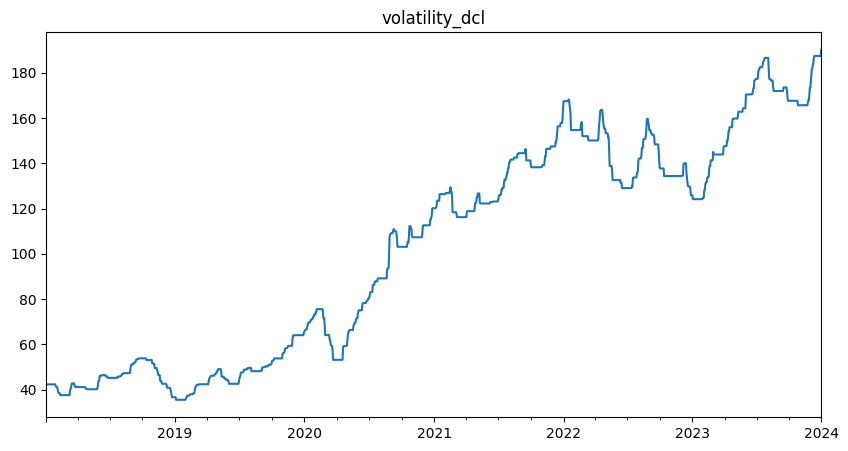

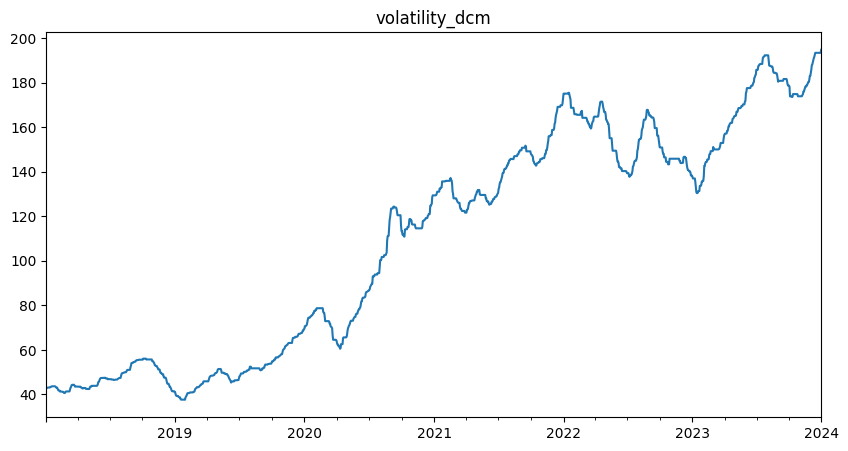

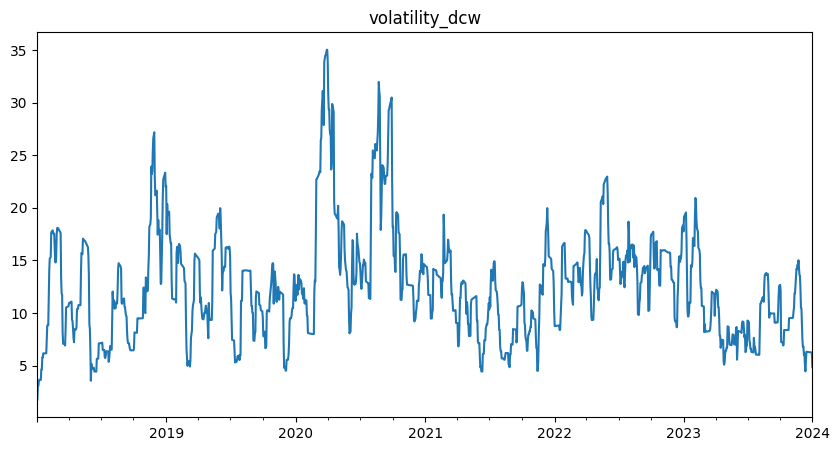

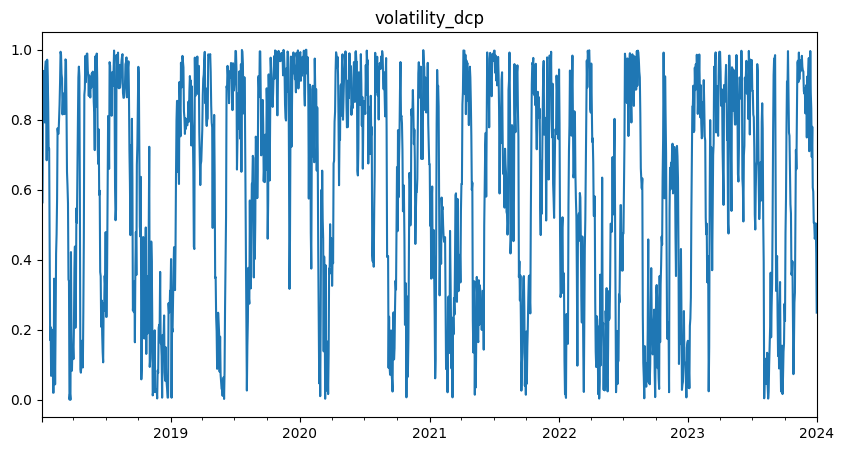

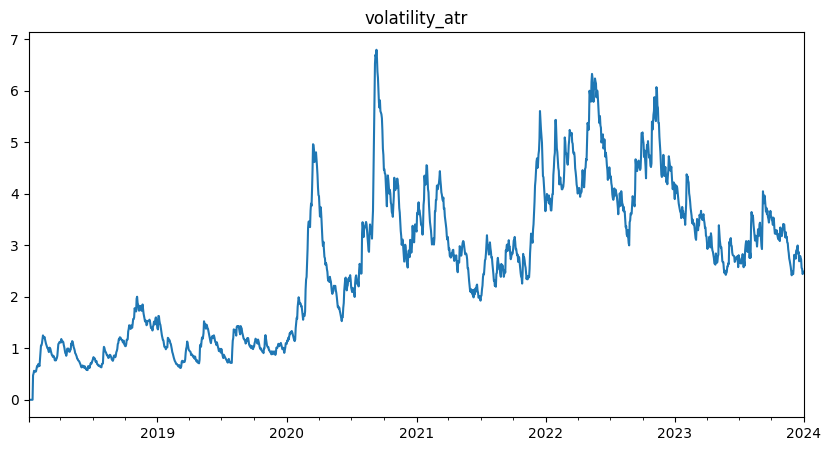

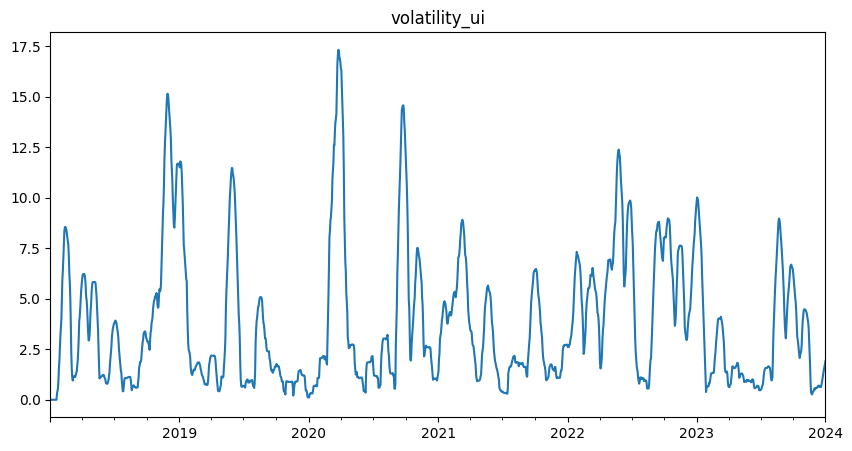

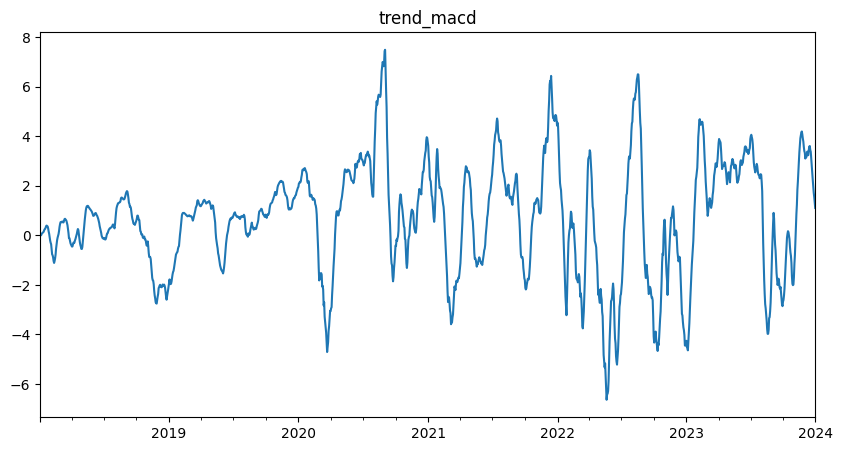

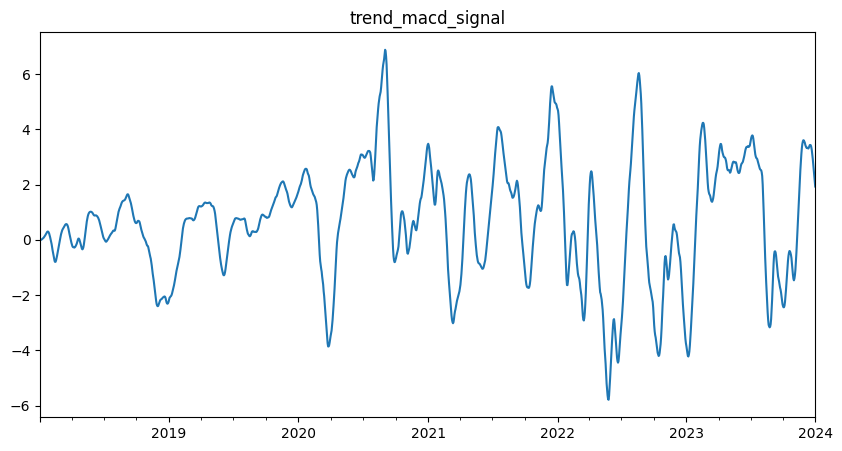

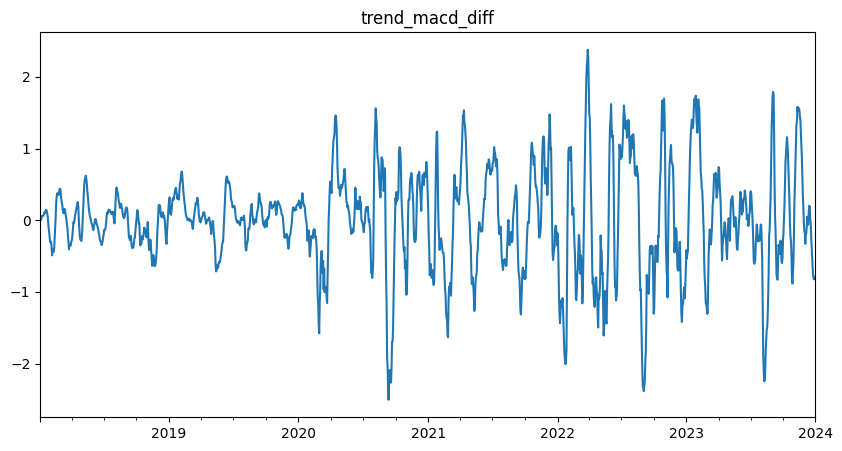

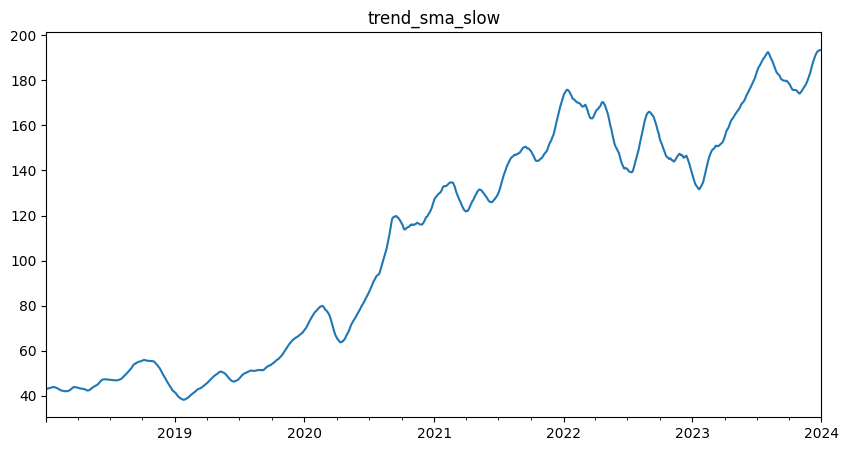

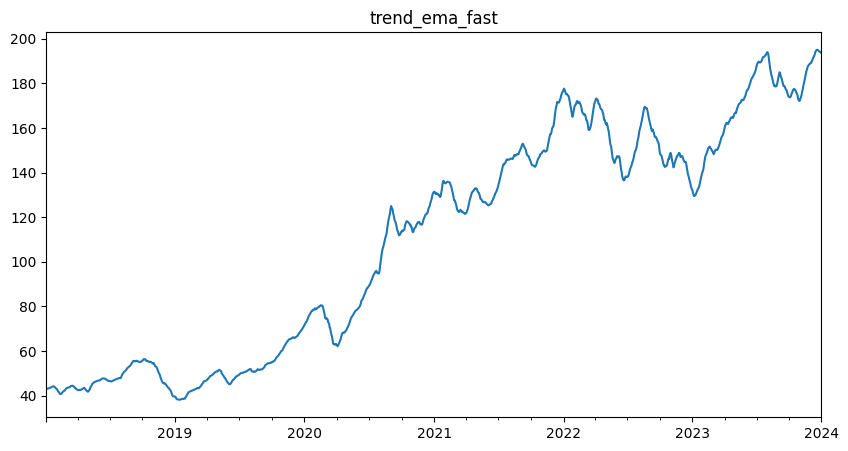

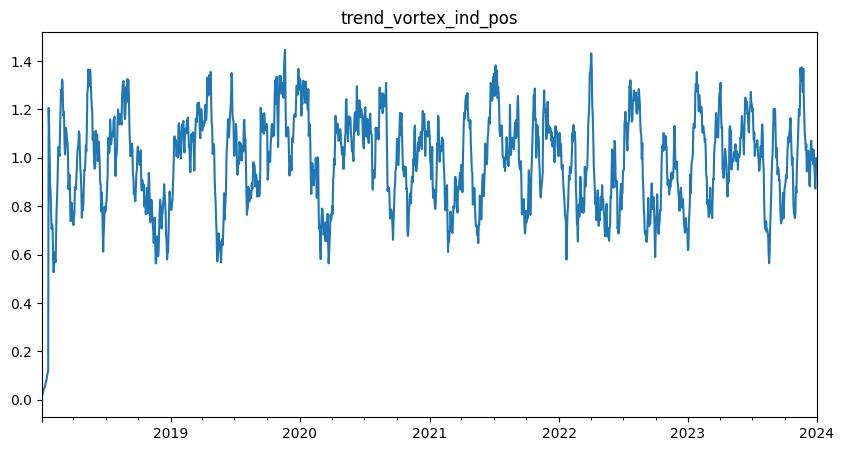

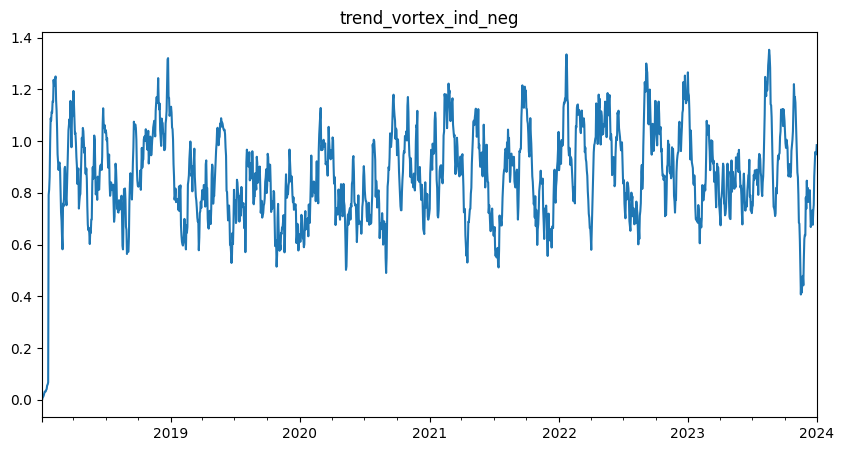

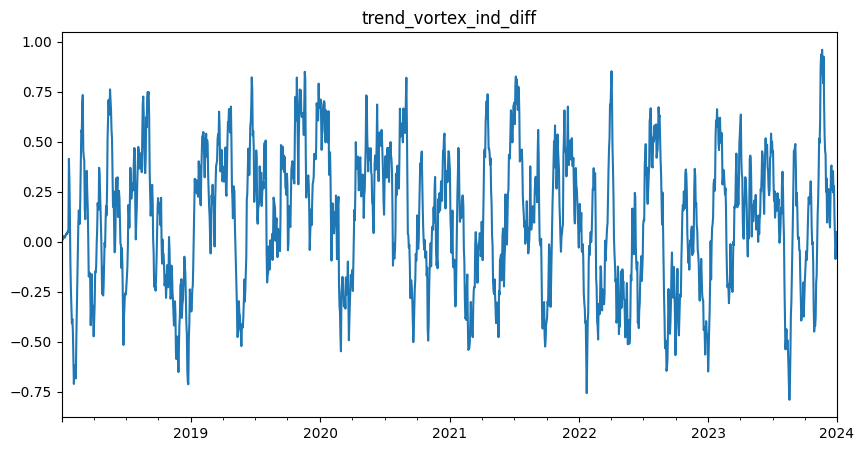

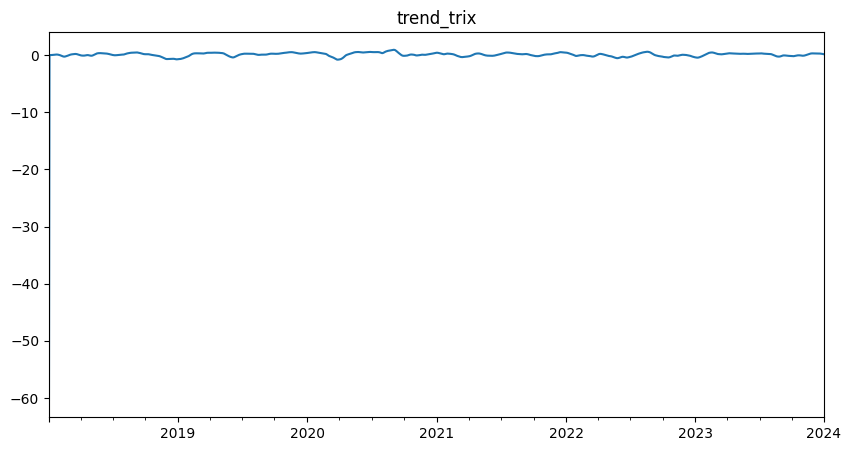

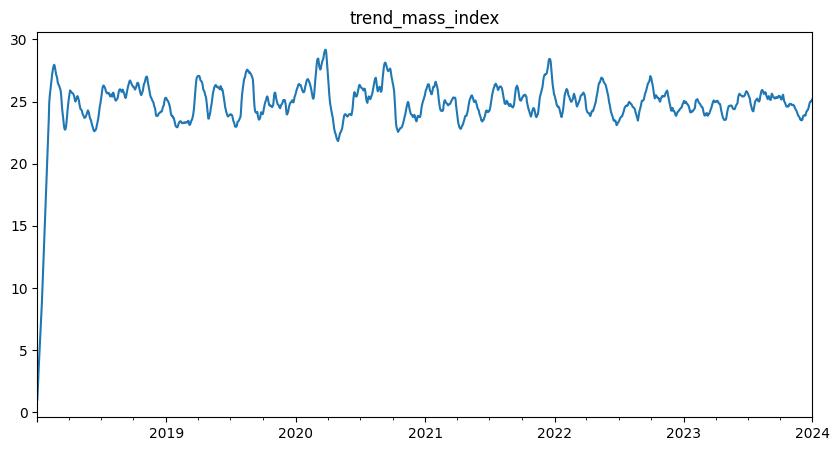

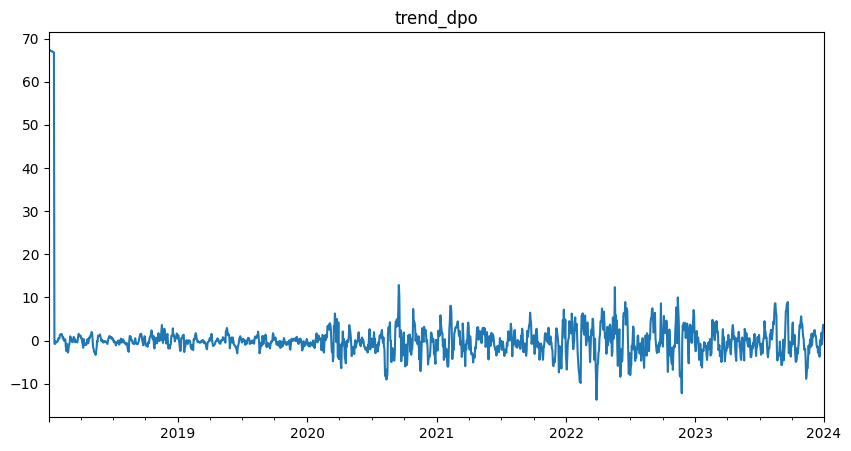

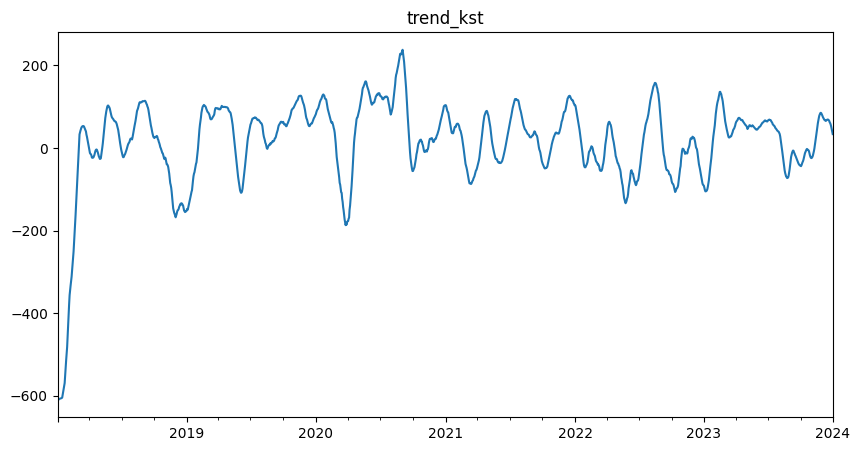

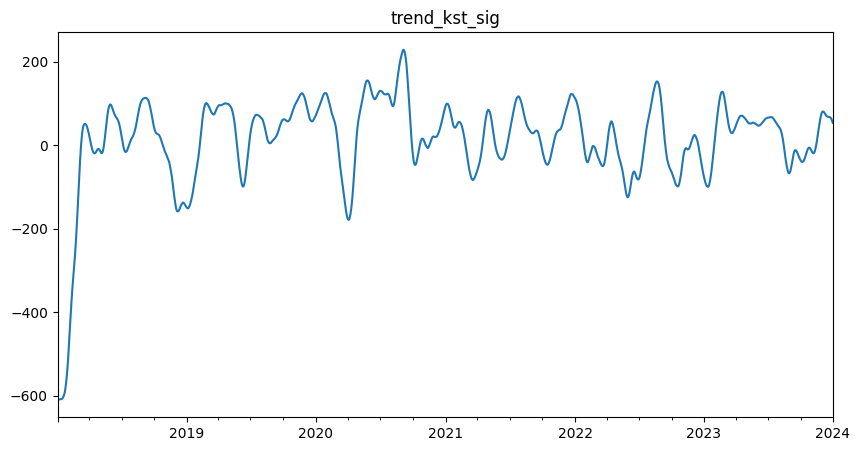

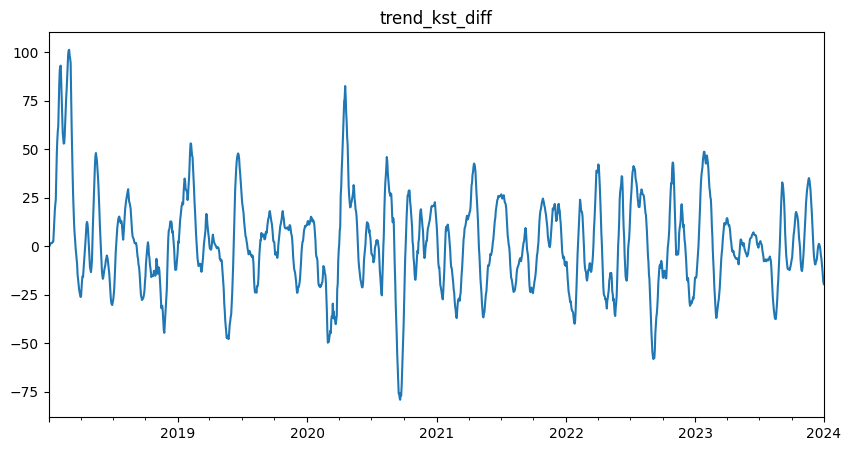

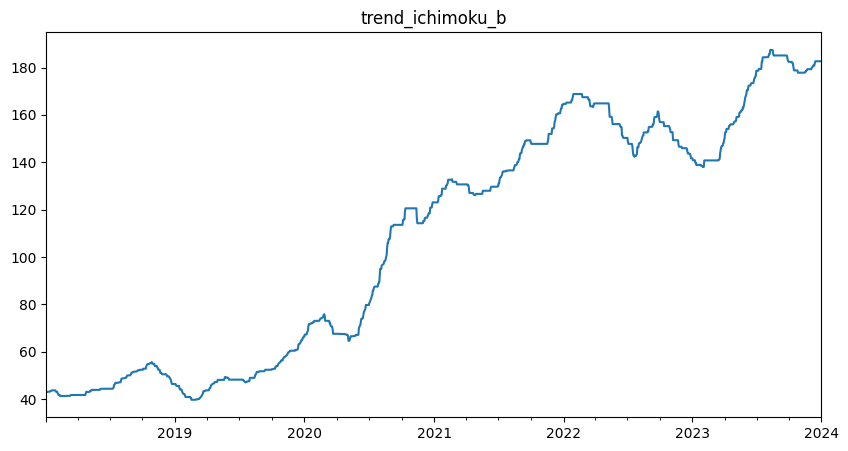

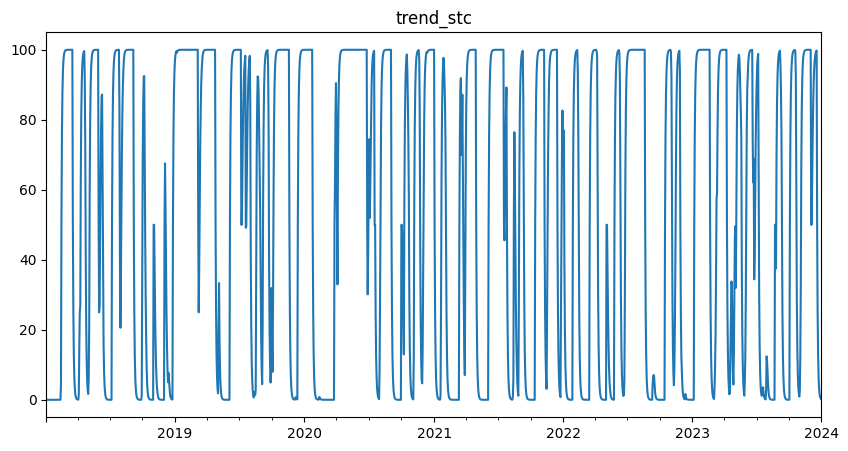

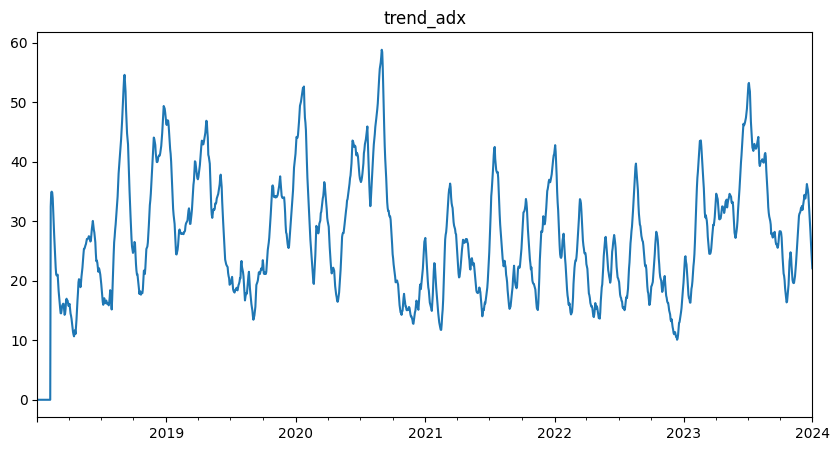

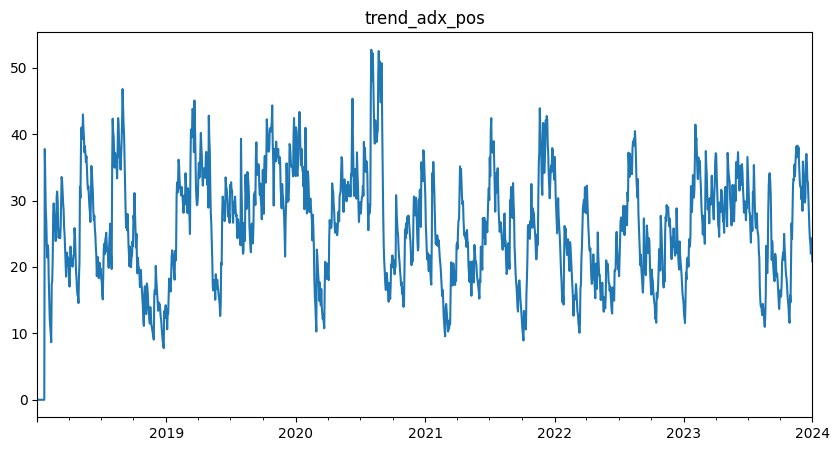

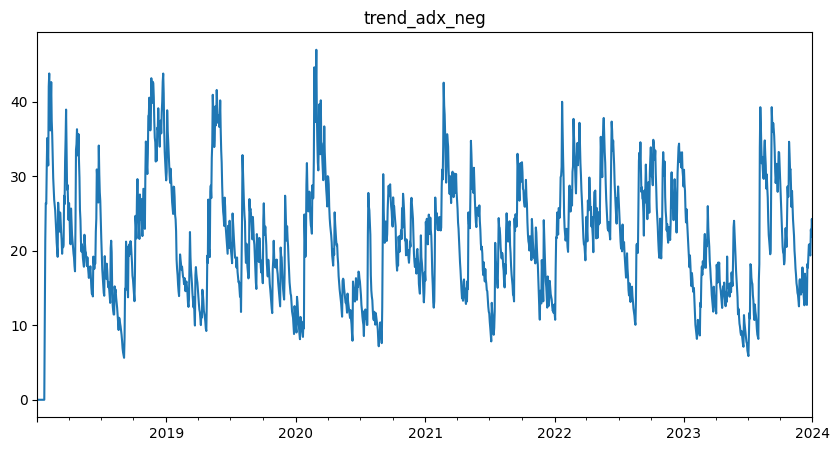

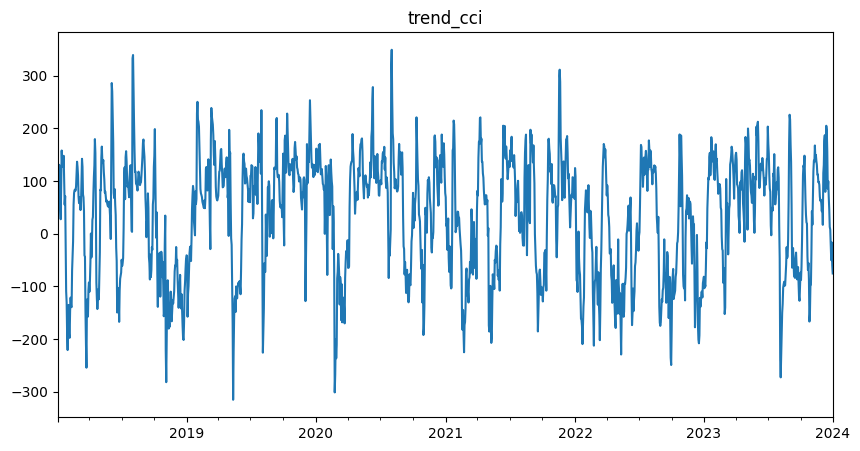

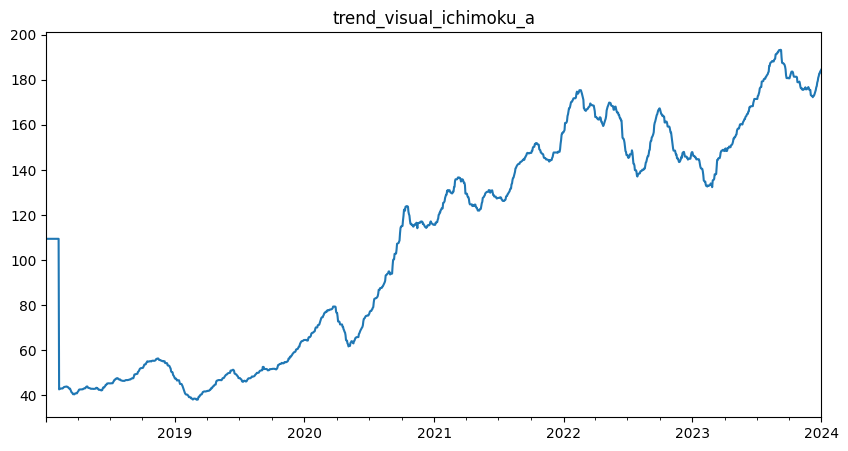

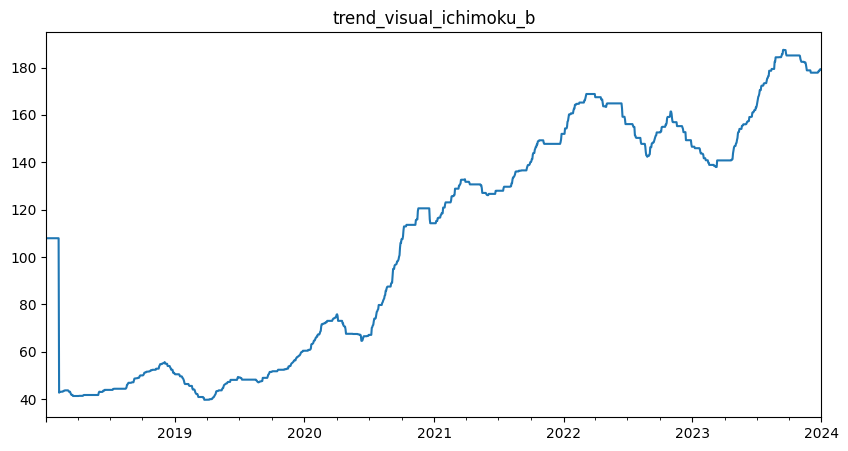

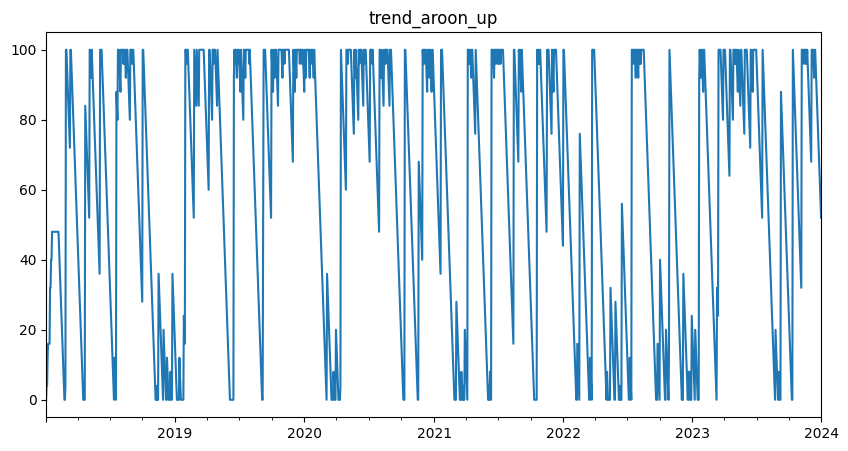

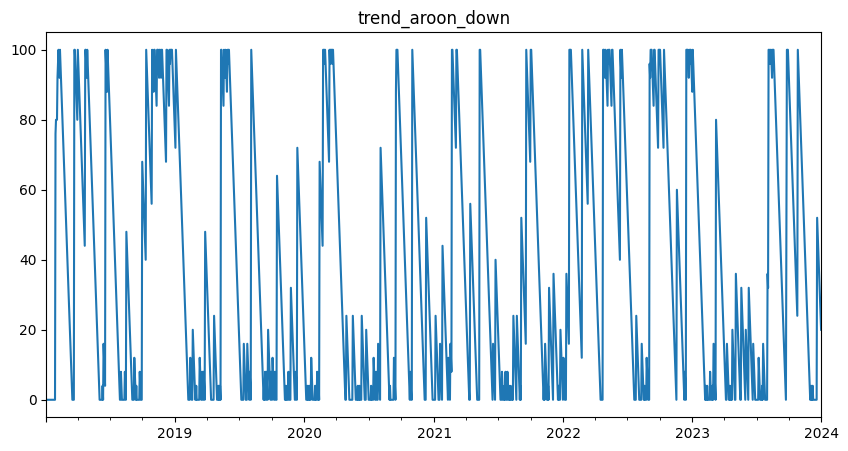

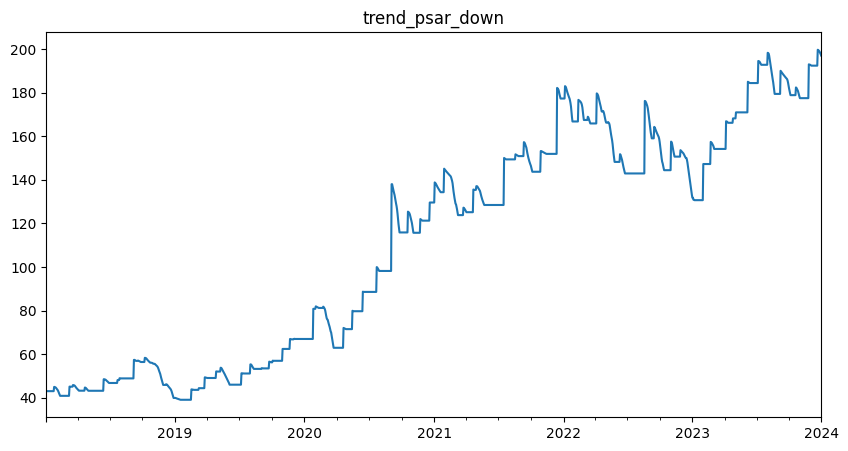

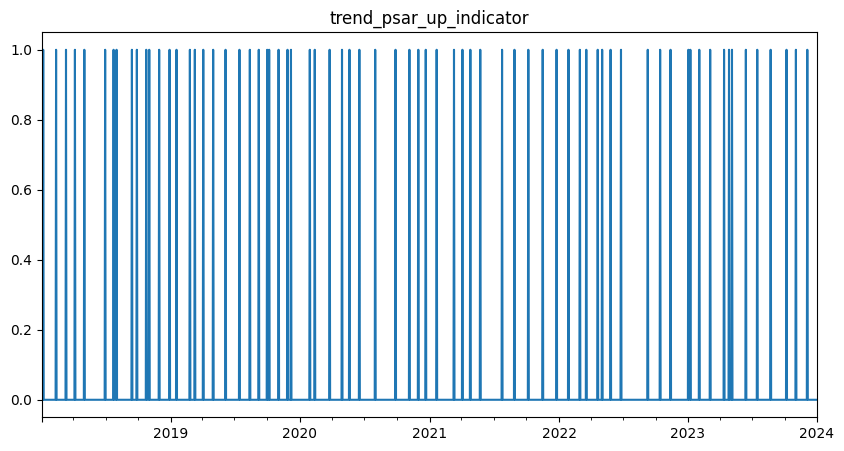

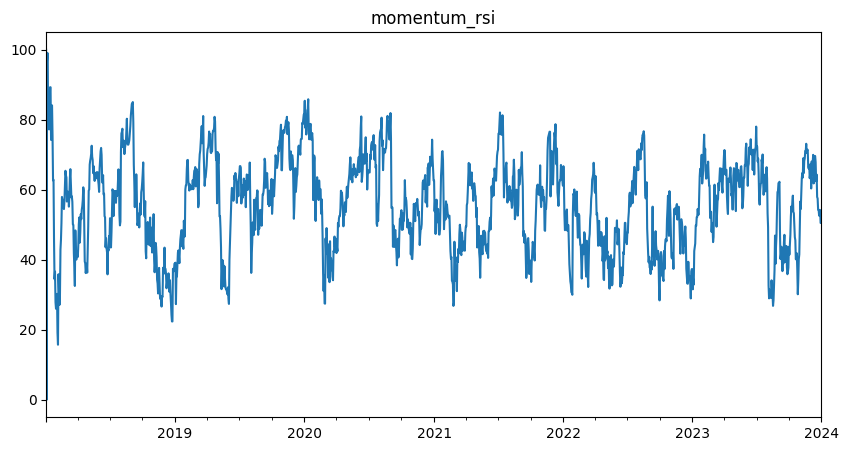

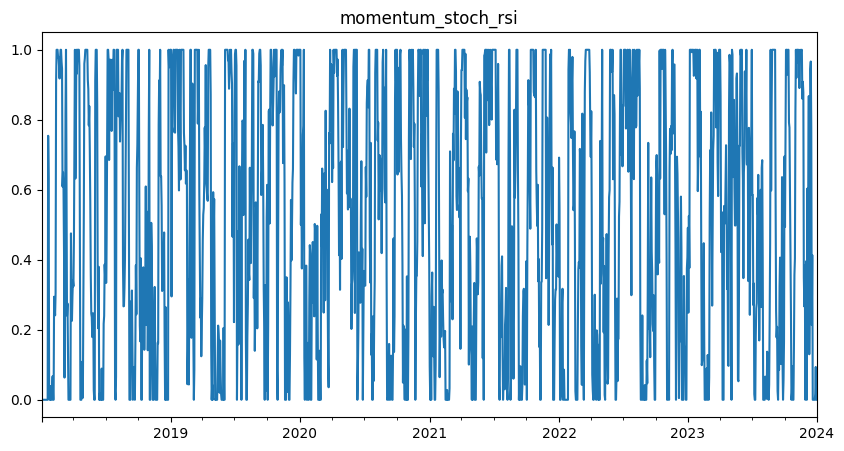

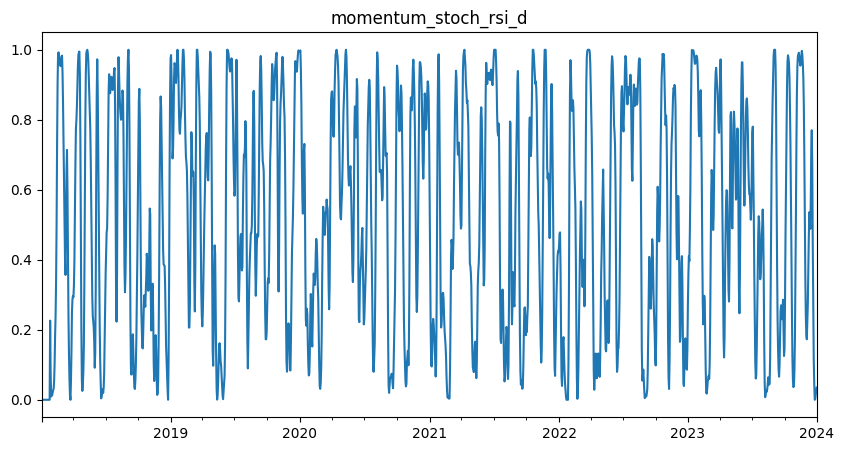

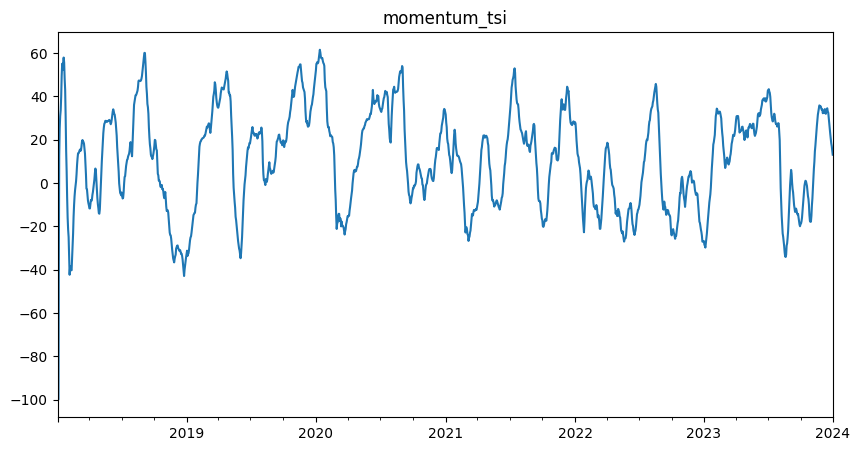

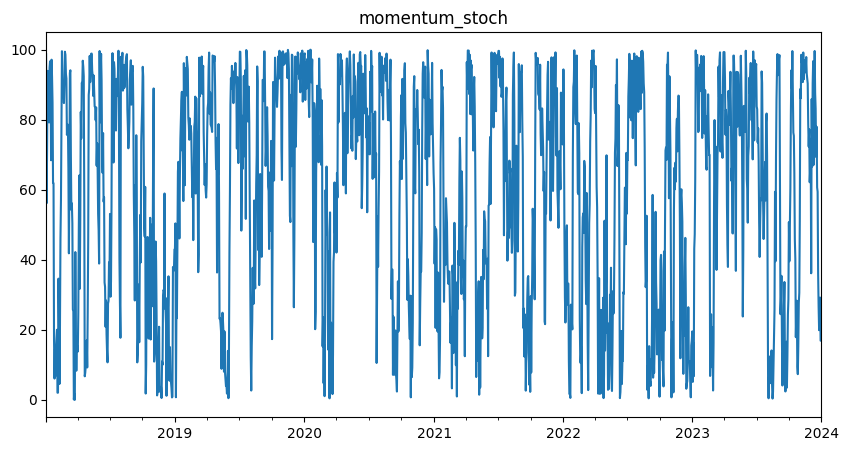

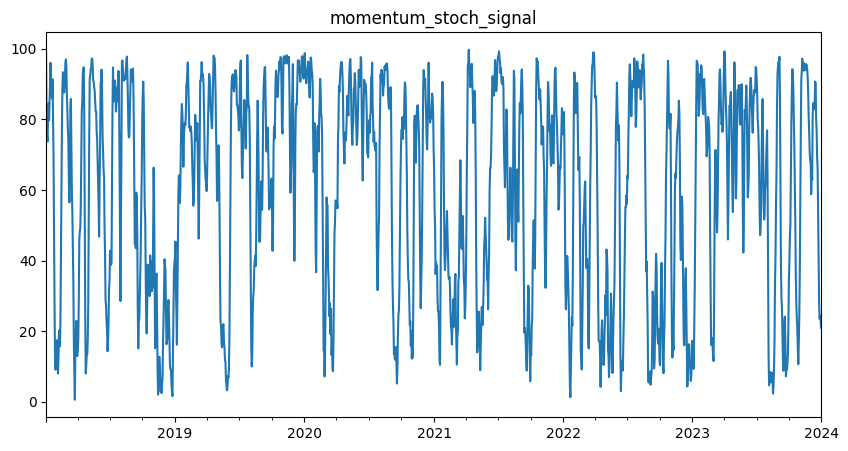

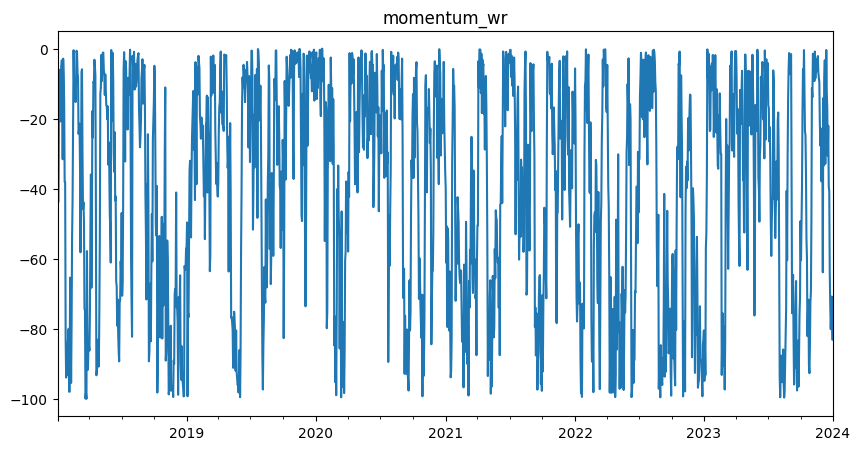

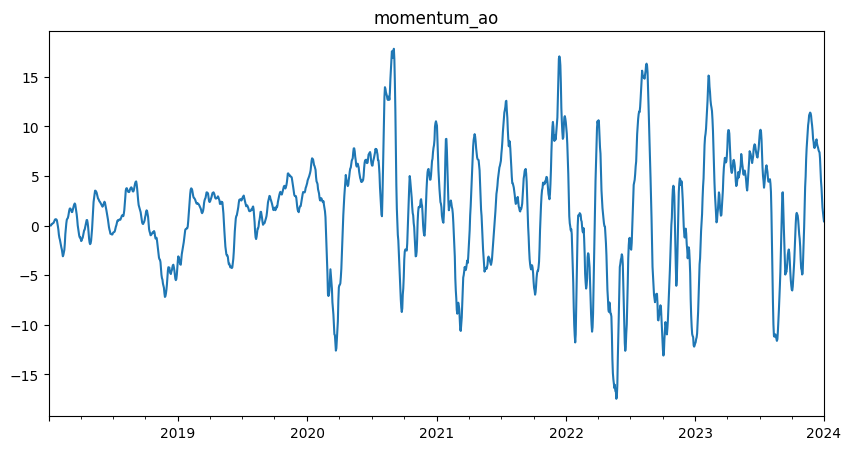

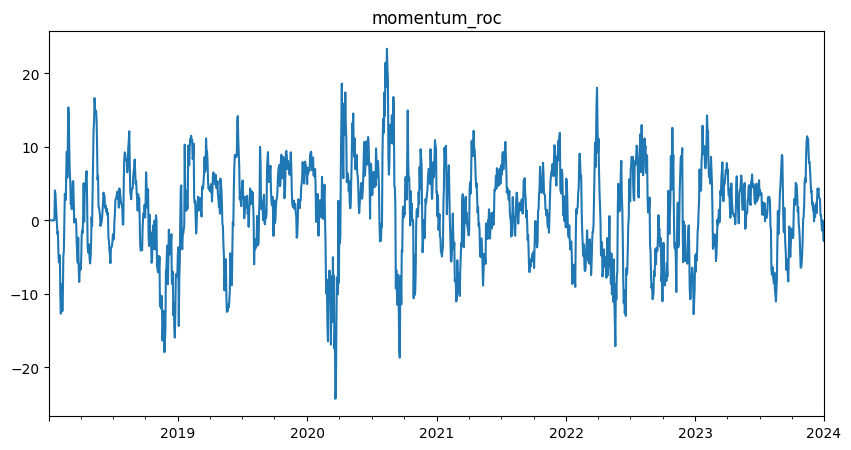

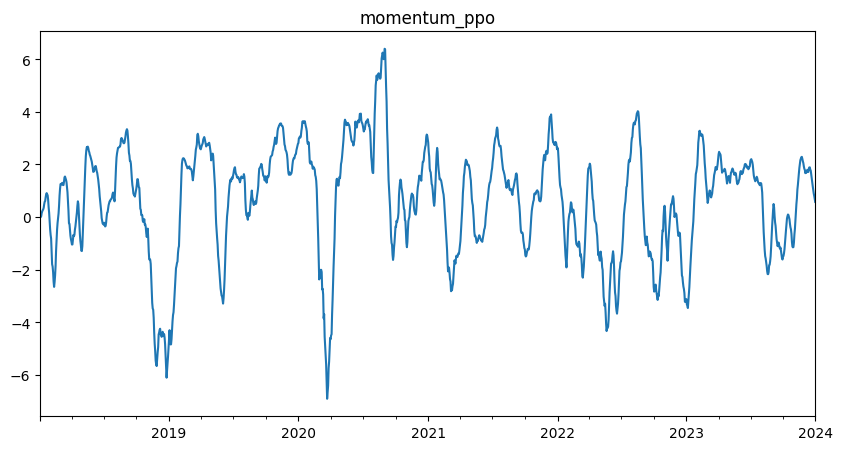

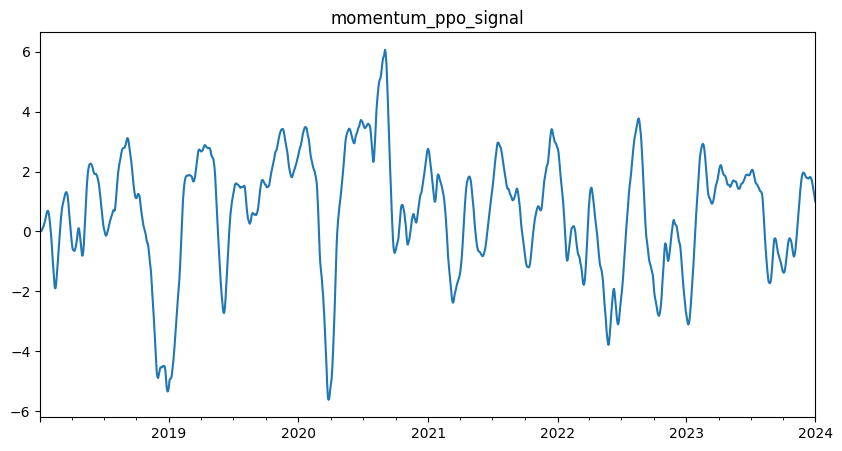

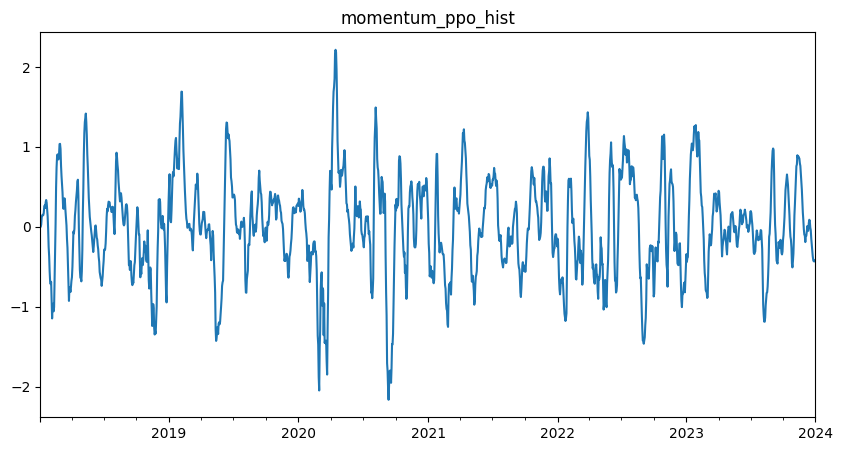

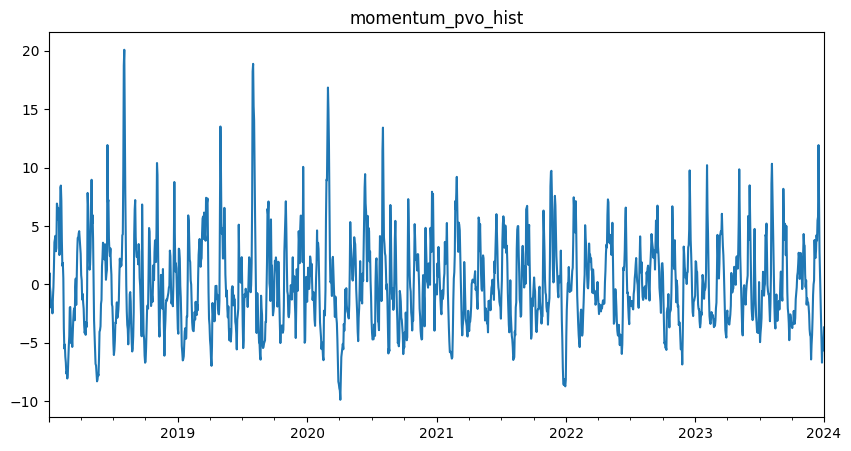

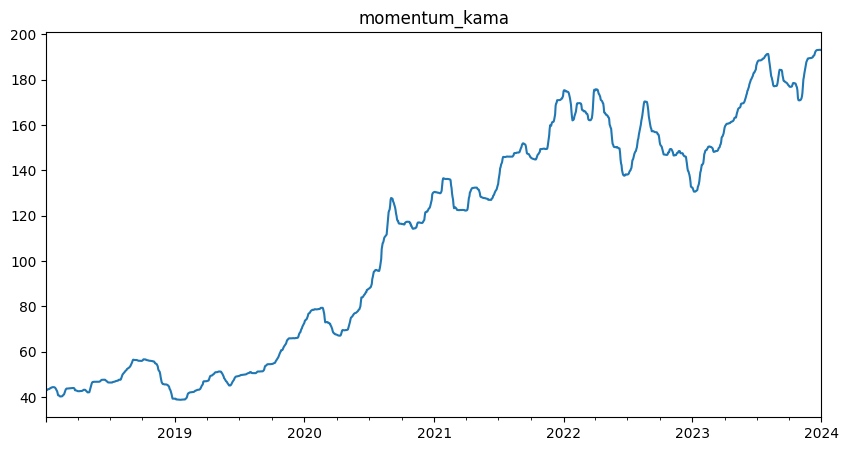

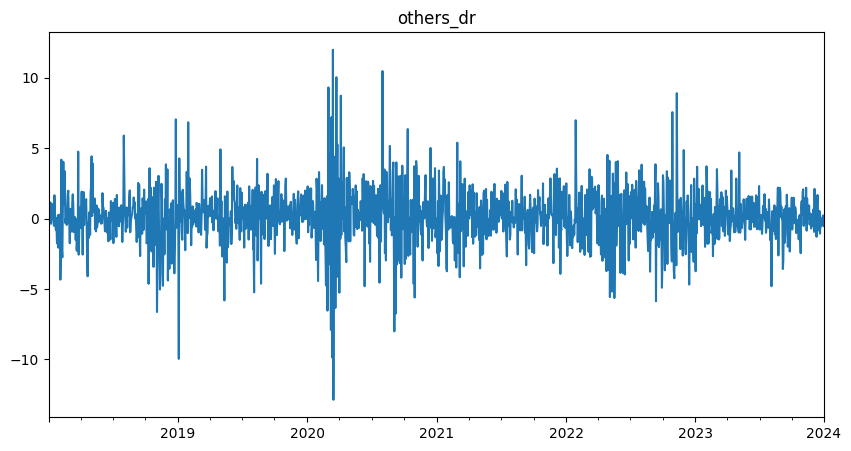

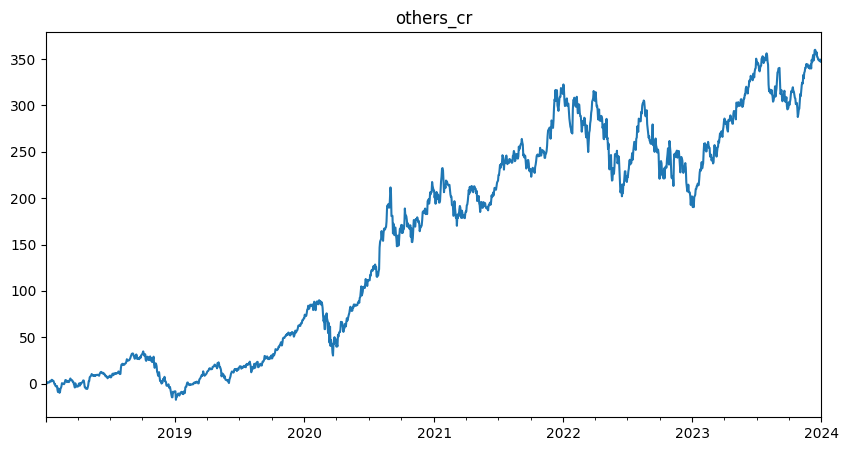

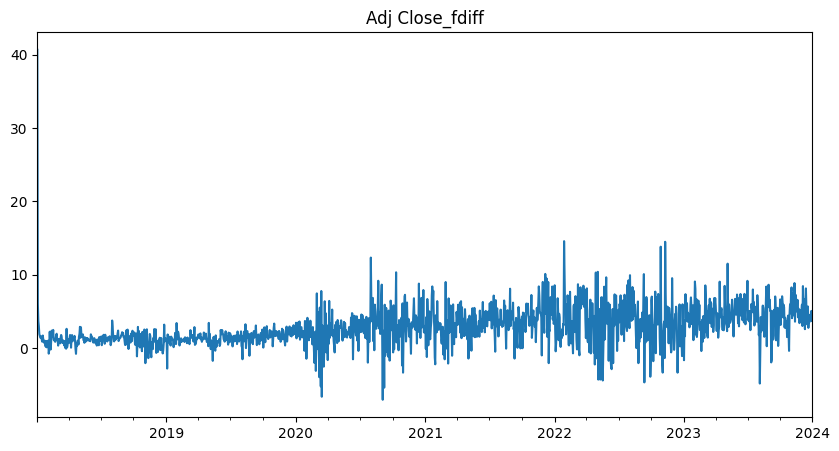

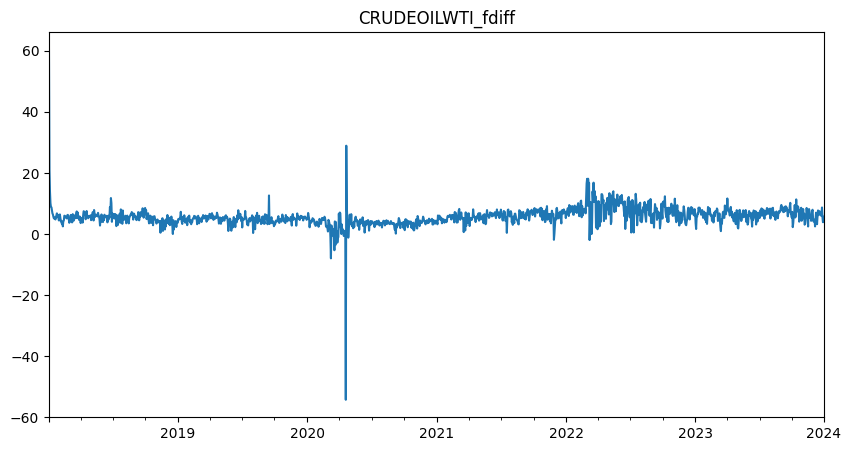

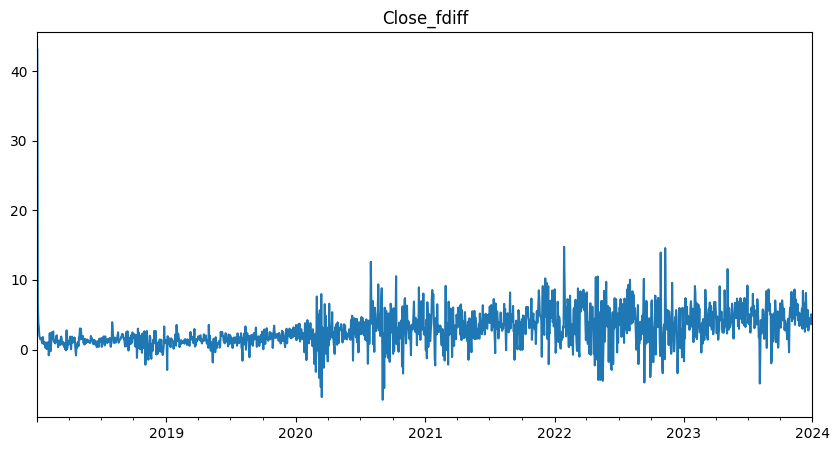

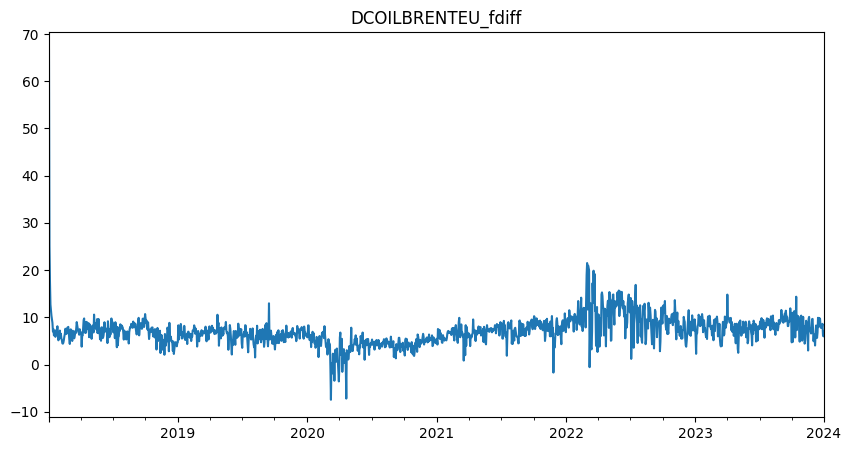

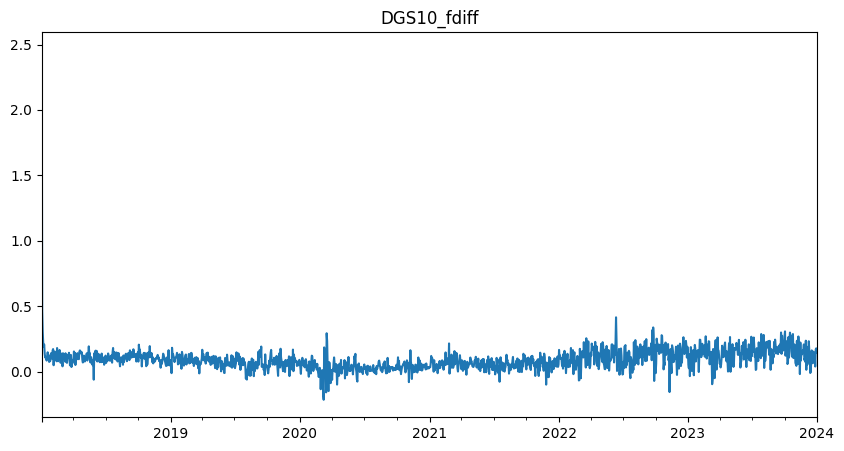

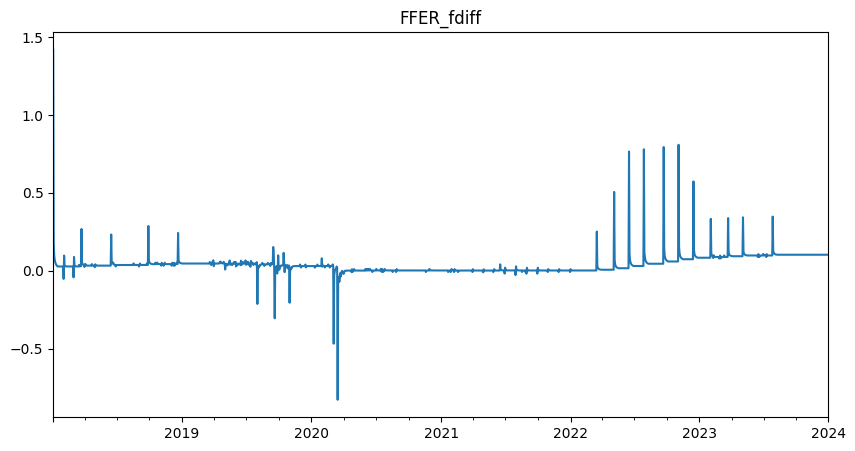

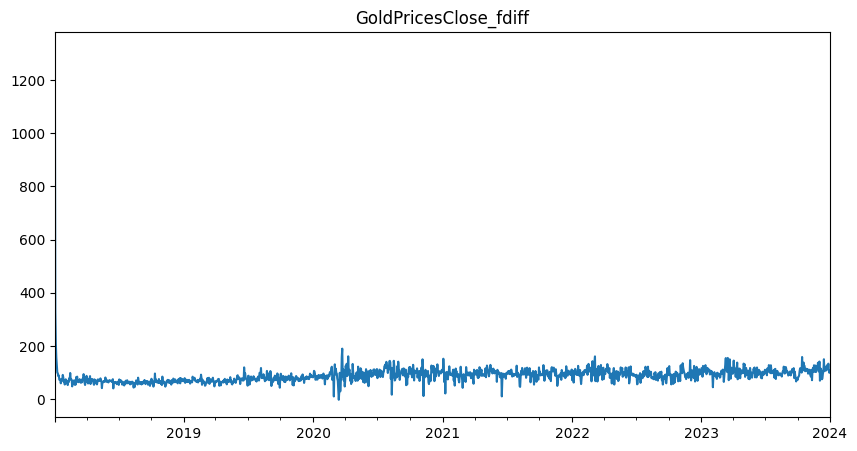

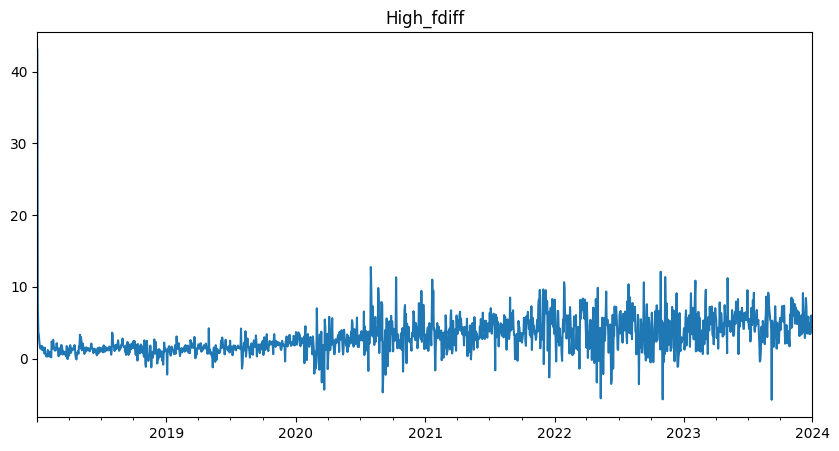

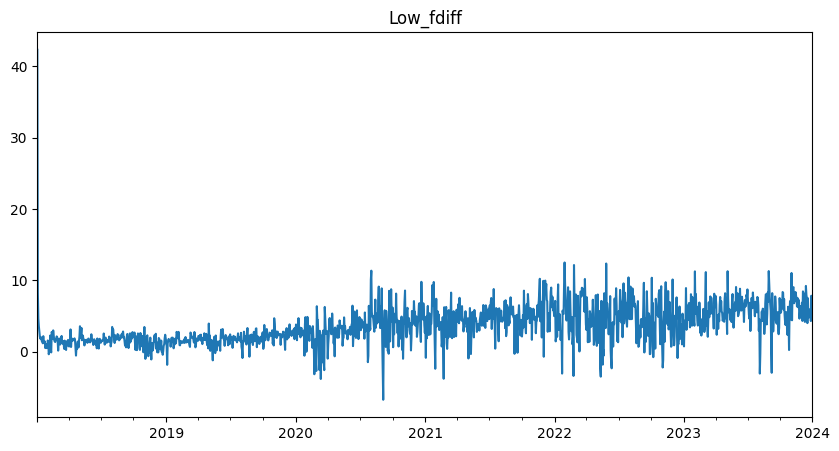

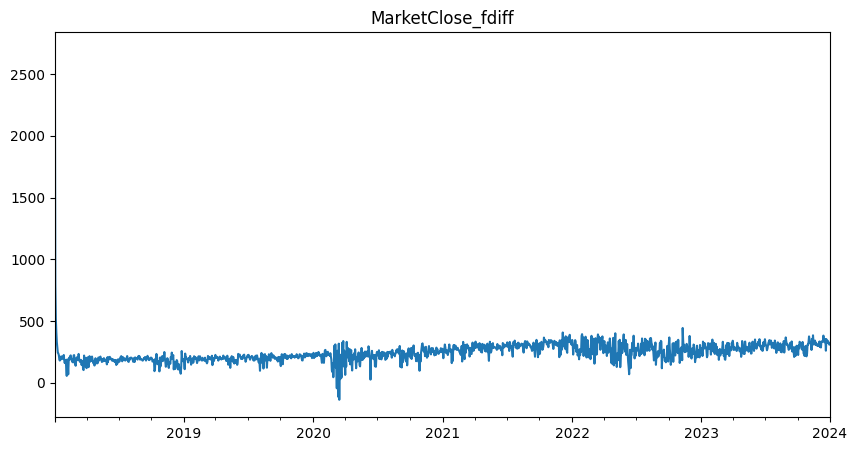

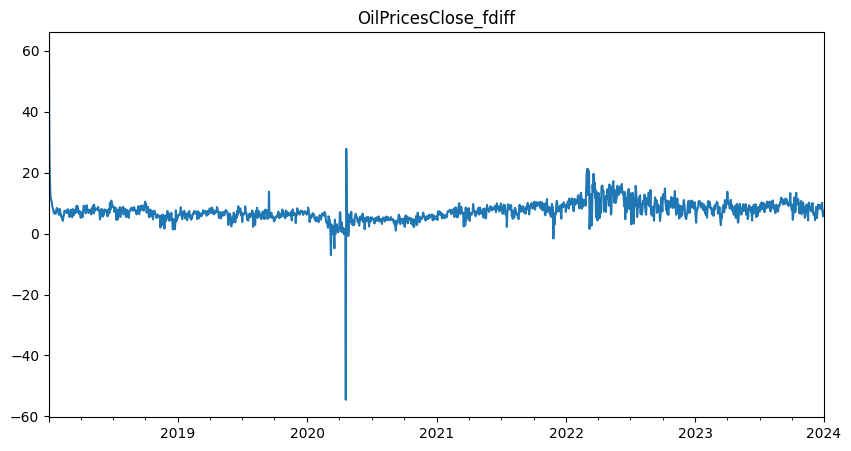

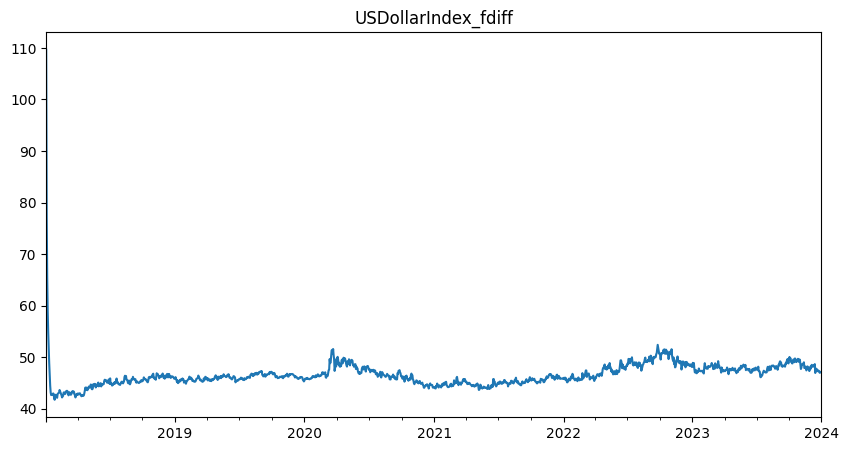

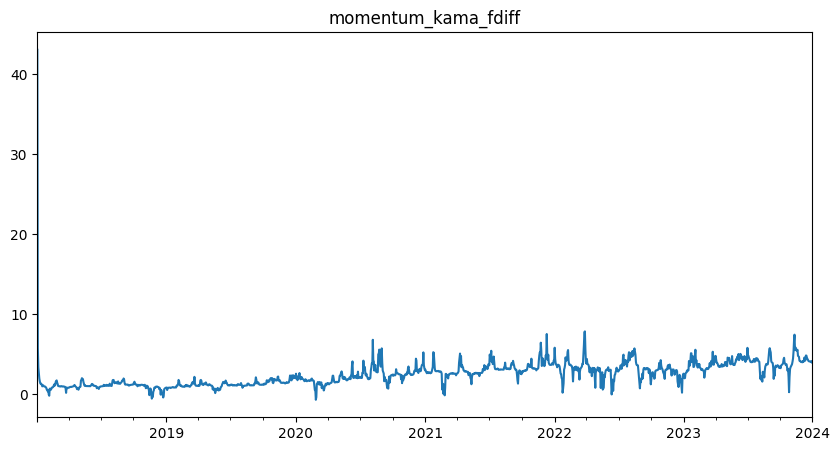

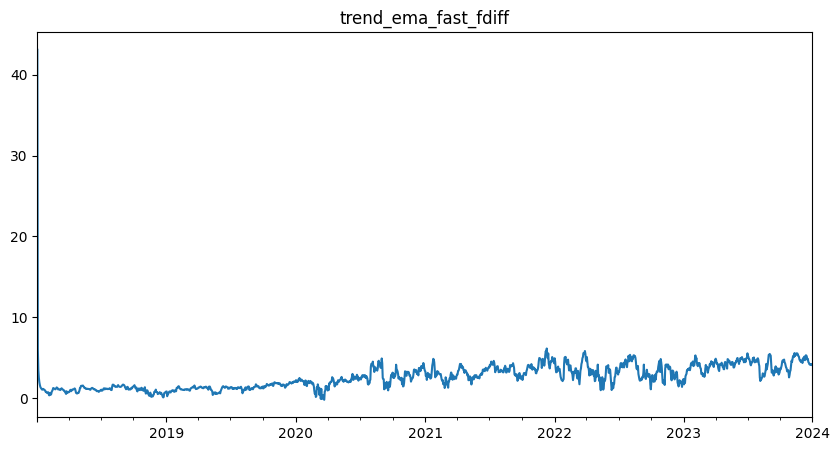

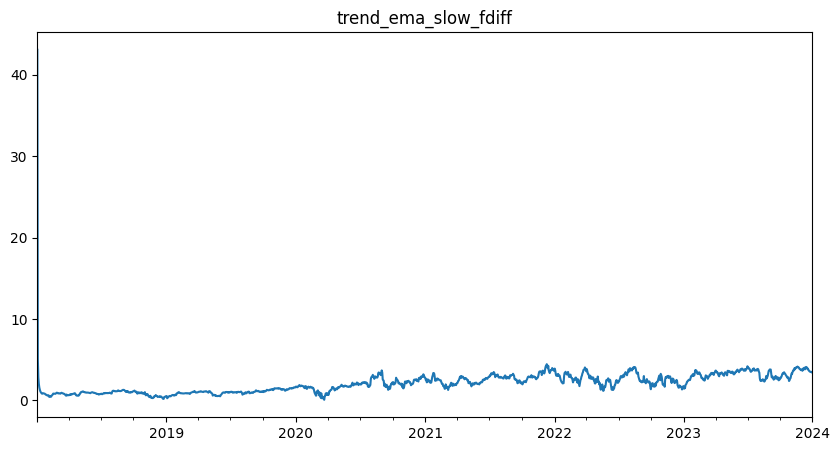

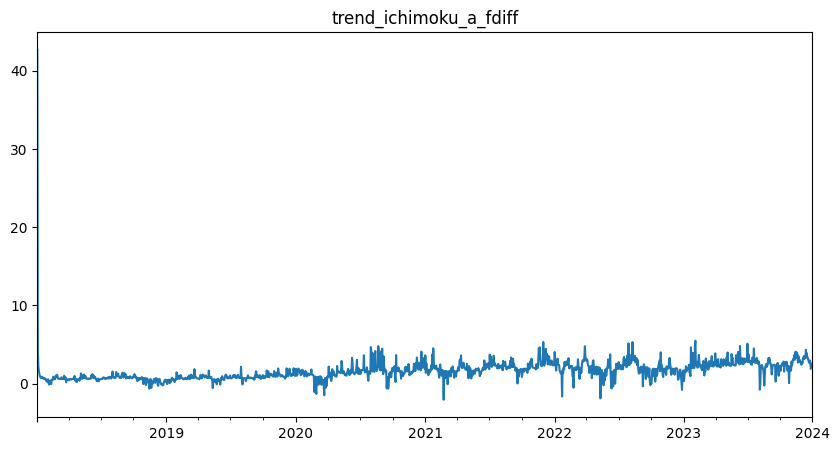

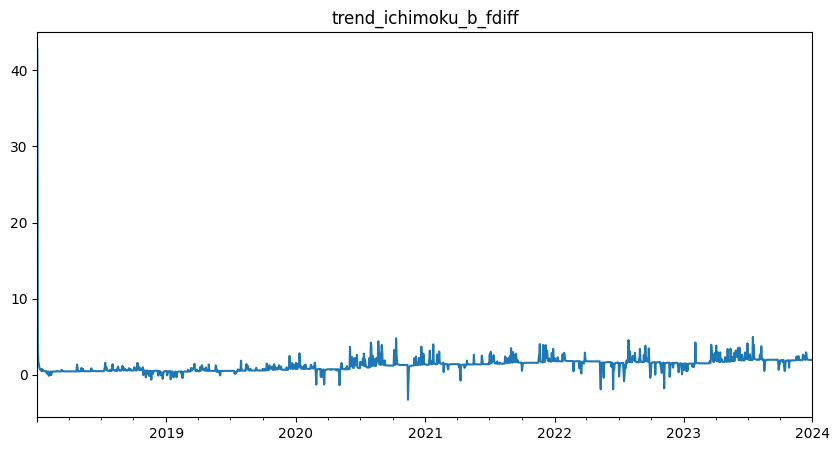

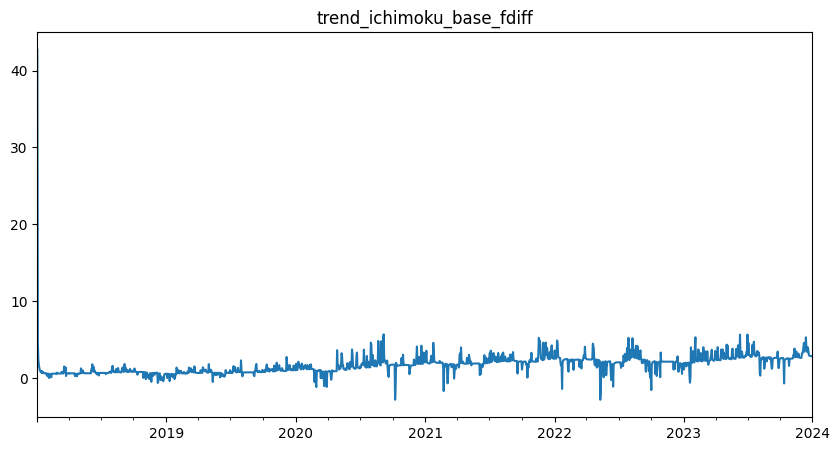

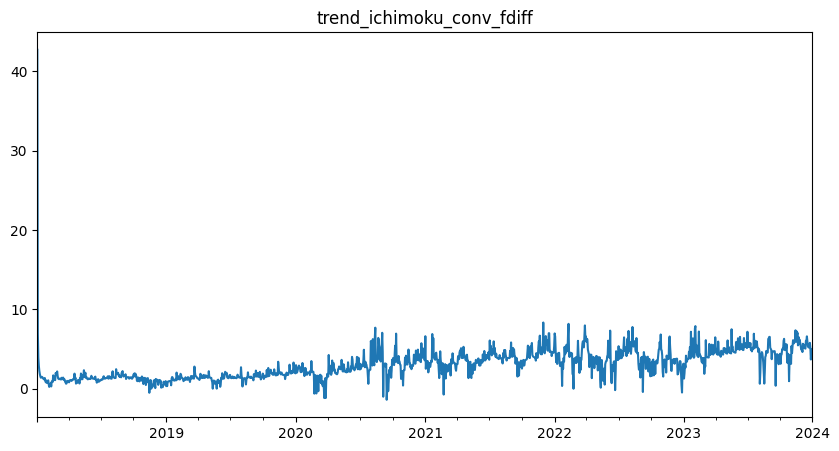

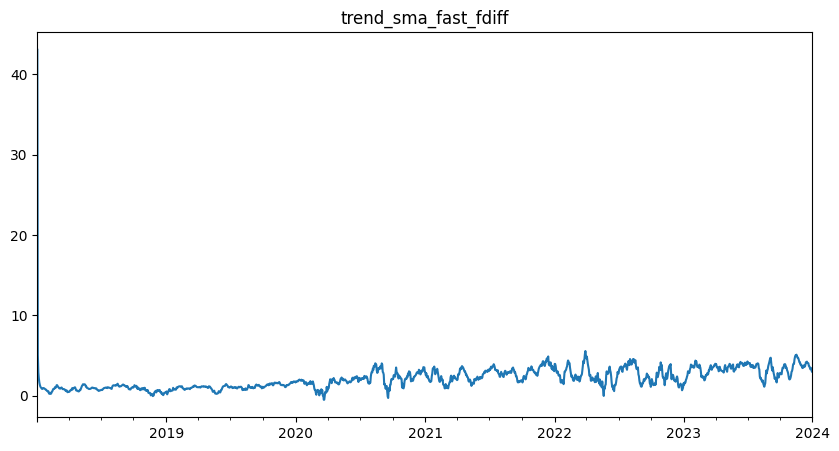

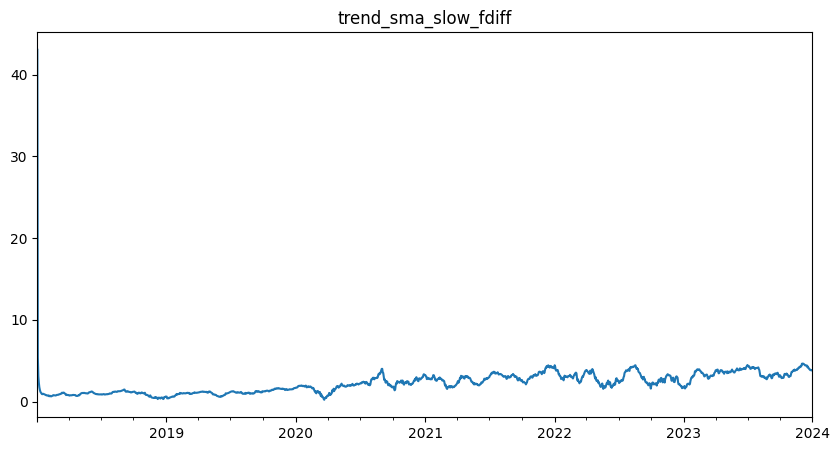

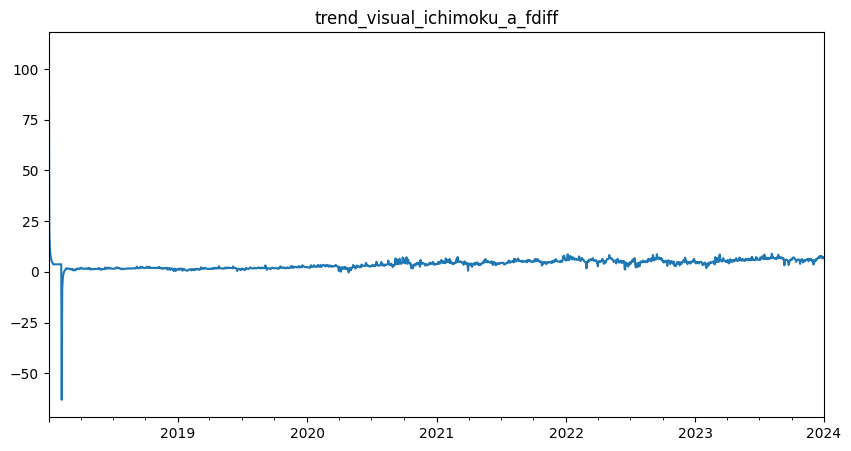

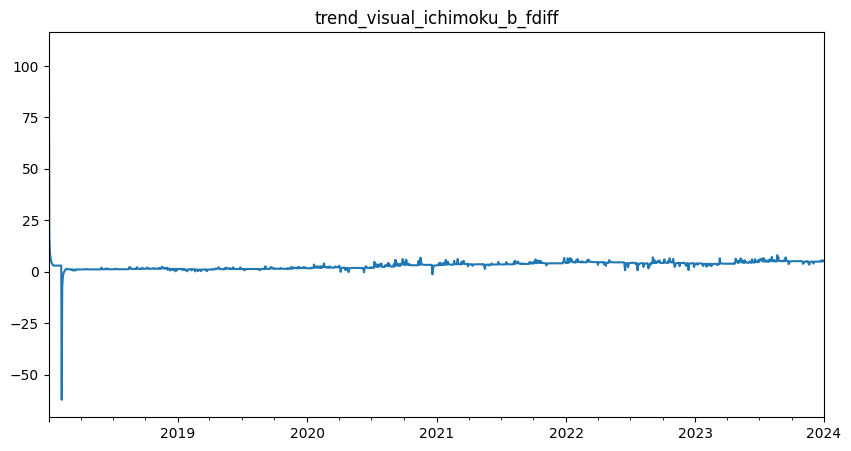

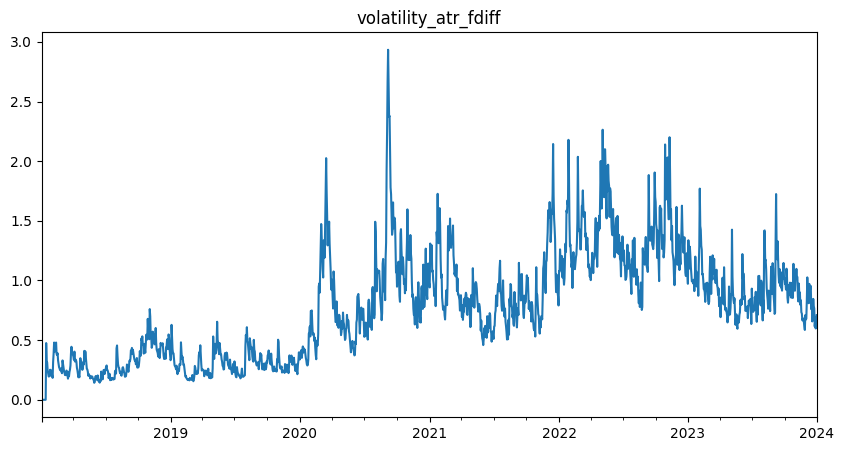

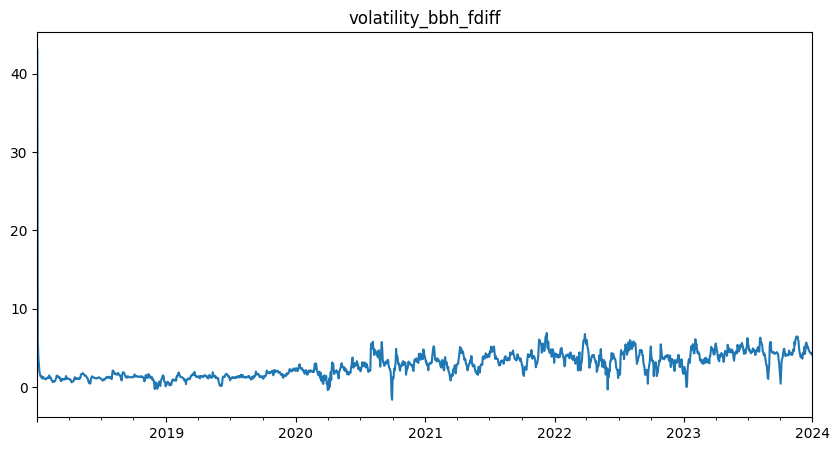

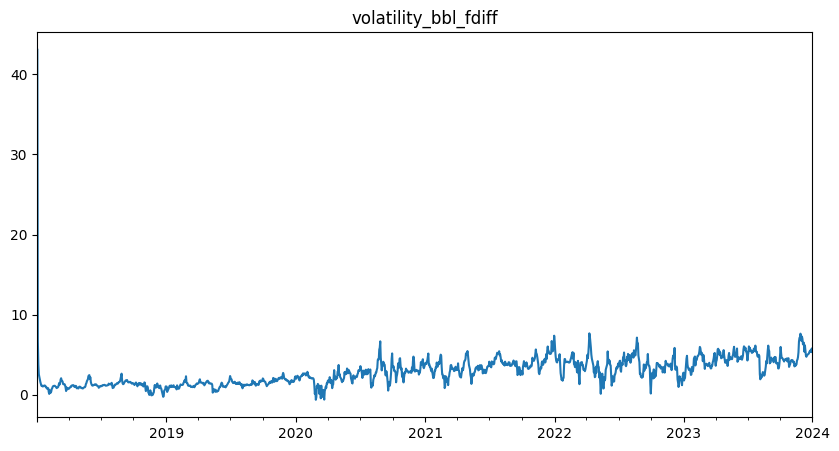

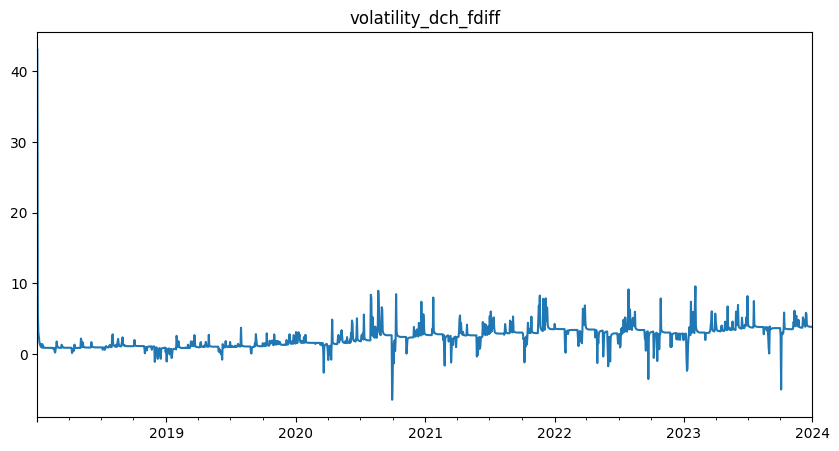

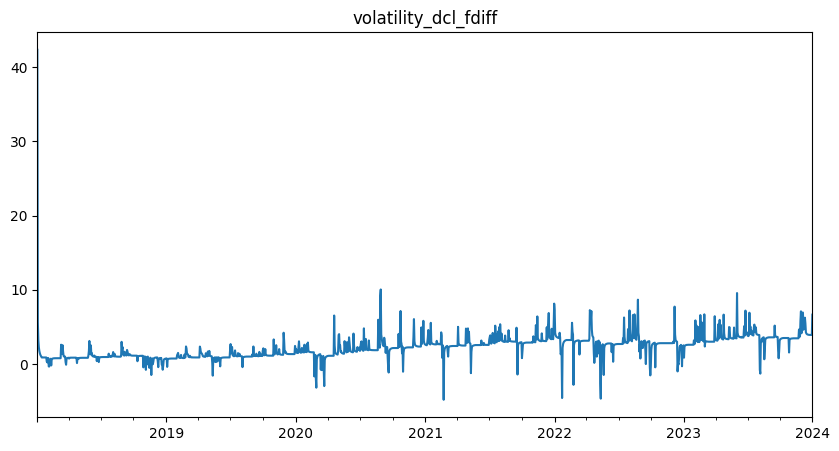

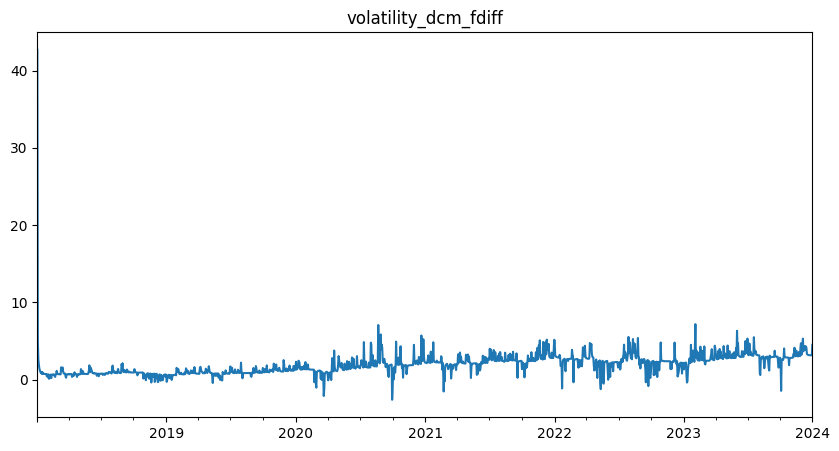

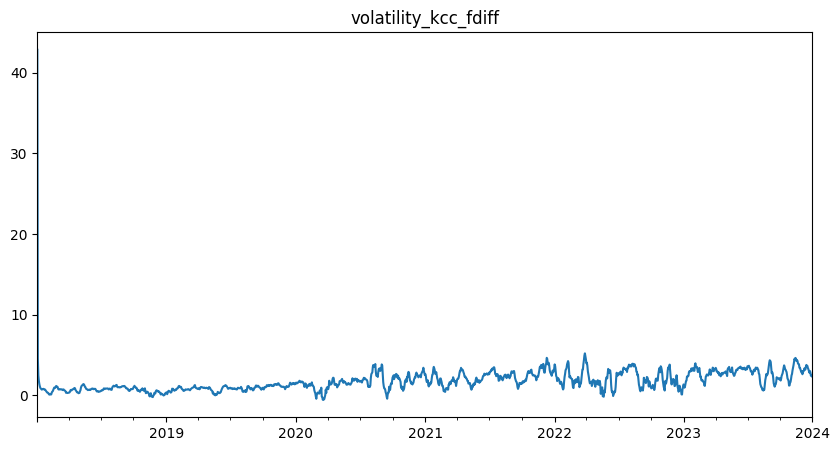

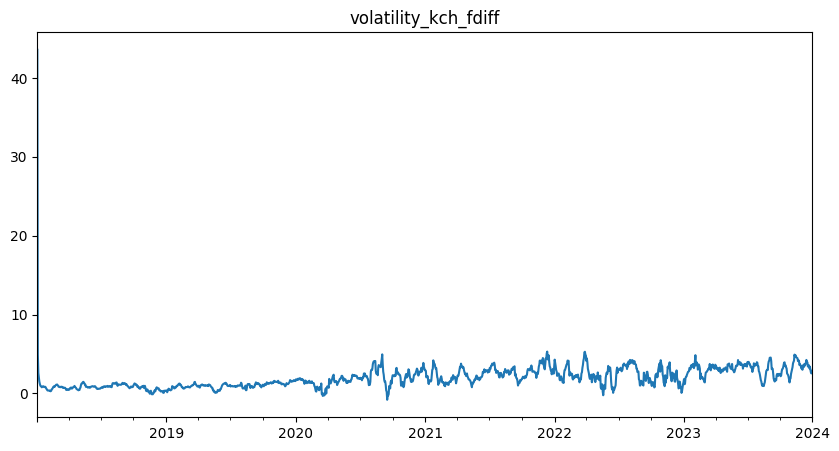

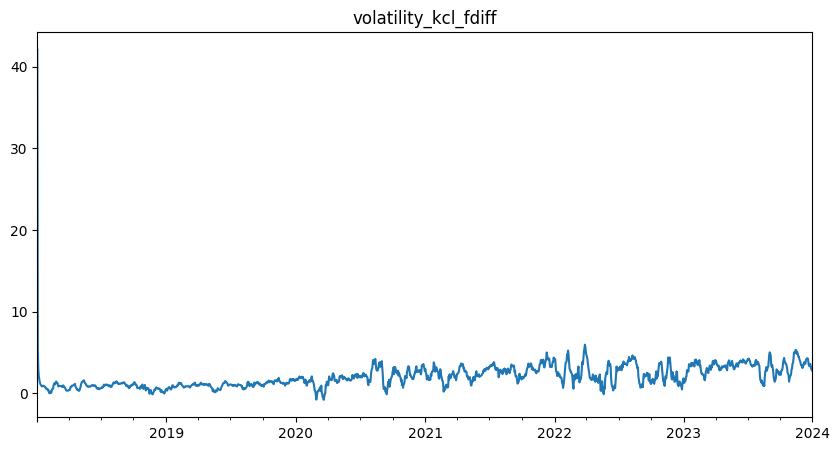

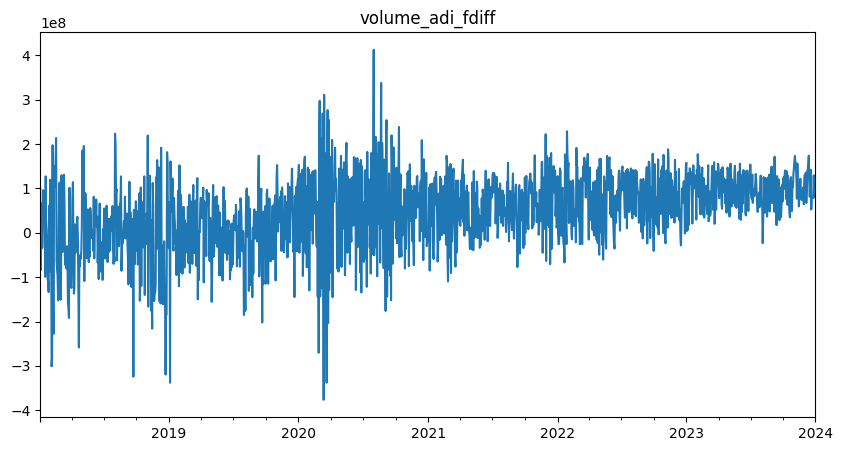

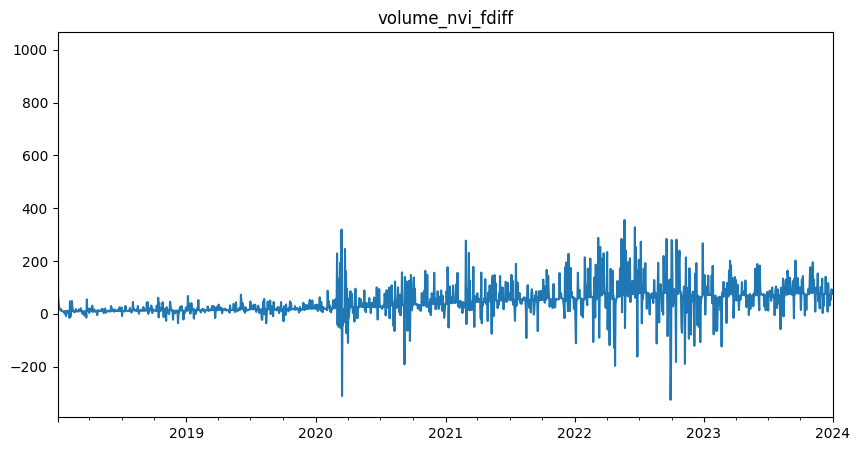

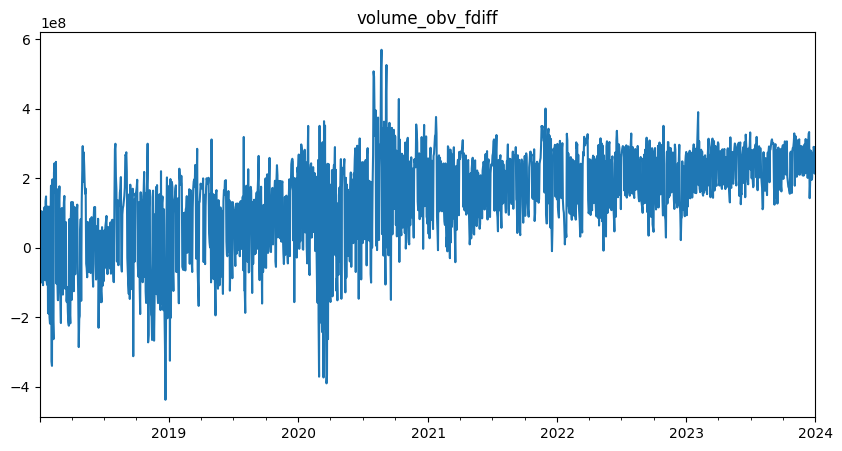

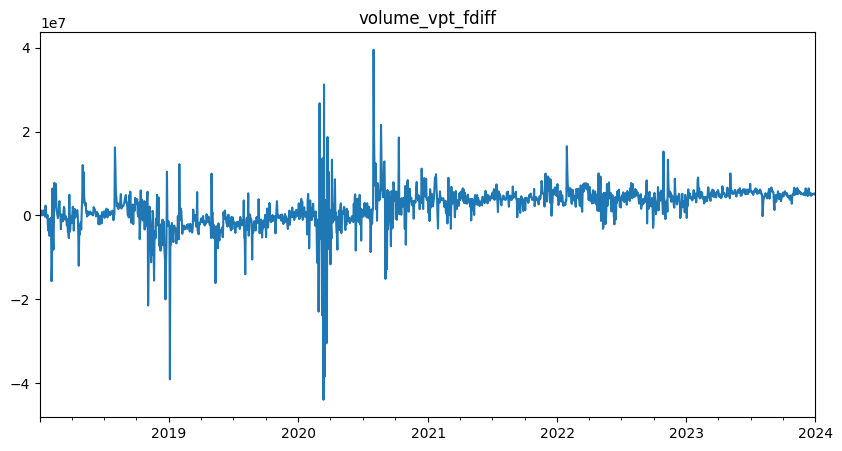

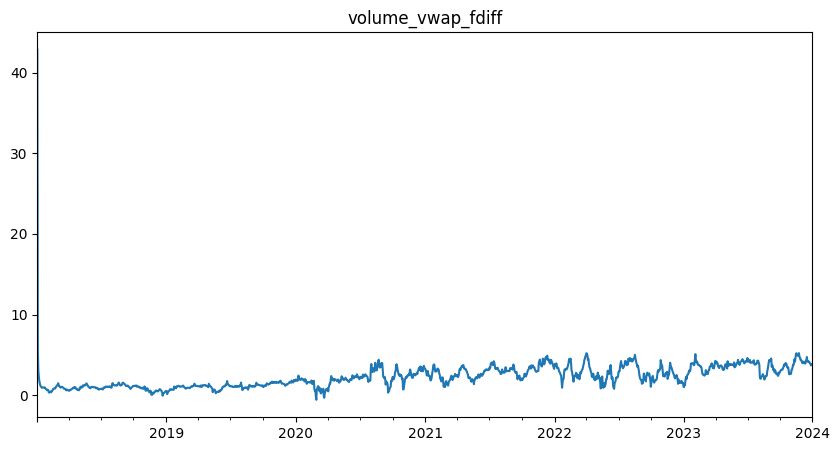

In [7]:
for column in X_train_selected:
        plt.figure(figsize=(10, 5))  # Adjust the size as needed
        final_dataset[column].plot()
        plt.title(column)
        plt.show()